#  0.0 IMPORTS

In [11]:
import pandas as pd
import inflection
import math
import numpy as np
from tabulate import tabulate

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb


from IPython.core.display import HTML 
from IPython.display import Image
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

import datetime

from datetime import timedelta

from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso


In [61]:
texto bem didático falando sobre o projeto de machine lear - parecendo com roteiro do curso
#http://carlosbaia.com/2016/12/24/decision-tree-e-random-forest/#:~:text=criterion%3A%20%C3%89%20a%20m%C3%A9trica%20utilizada,treinamento%2C%20tamb%C3%A9m%20conhecido%20como%20overfitting.

# 0.1 HELPER FUNCTIONS

In [7]:



def mean_percentage_error( y , yhat ):
    return np.mean( ( y - yhat) / y )


def mean_absolute_percentage_error( y,yhat):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error(model_name, y , yhat ):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error ( y, yhat )
    rmse = np.sqrt( mean_squared_error( y,yhat) )
    
    return pd.DataFrame( { 'Model name':model_name,
                           'Mae': mae,
                           'Mape': mape,
                           'Rmse':rmse }, index=[0] )


def cramer_v ( x, y):
    
    cm =pd.crosstab ( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2correção = max( 0, chi2 -(k - 1)*(r -1) / ( n -1 ))
    kcorreção = k - (k - 1)**2 / (n - 1)
    rcorreção = r - (r - 1)**2 / ( n - 1)
    
    return np.sqrt( ( chi2correção/n ) / ( min (kcorreção -1 , rcorreção - 1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [8]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 LOARDING DATA


In [12]:
df_sales=  pd.read_csv(r'C:\Users\Administrador.000\Google Drive\repositorio\DS Produção/train.csv',low_memory=False)

df_store = pd.read_csv(r'C:\Users\Administrador.000\Google Drive\repositorio\DS Produção/store.csv',low_memory=False)

df_mesclar = pd.merge(df_sales,df_store, how='left',on='Store' )



In [7]:
df_mesclar.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
357620,754,7,2014-08-24,0,0,0,0,0,0,c,c,380.0,5.0,2008.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"


#  1.0 DESCRIÇÃO DOS DADOS


In [13]:
df1 = df_mesclar.copy()

In [14]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [15]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snackcase= lambda x: inflection.underscore( x )

new_cols = list(map(snackcase,cols_old))

df1.columns = new_cols

display(new_cols)

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

## 1.2 Data Dimension 

In [16]:
print('Number of Rows {}'.format(df1.shape[0])) #também chamada de muitas vezes entradas
print('Number of Cols {}'.format(df1.shape[1])) #tabém chamada de features

Number of Rows 1017209
Number of Cols 18


## 1.3 Data Types

In [17]:
df1['date'] =pd.to_datetime(df1['date'])

df1.dtypes




store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA


In [9]:
#total de dados faltantes dentro do arquivo
df1.isna().sum() 

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
16147,538,5,2015-07-17,3967,577,1,1,0,0,a,a,990.0,2.0,2010.0,0,NaN,NaN,NaN


In [18]:

print(df1['competition_open_since_month'].max())

12.0


In [19]:
# importar a bibilioteca math (matematica), pois esse pacote contém math.isnan que faz o calculo média das dataas para não ficar vazio.

#competition_distance (compentição em metros- isso quer dizer a distância de uma loja para outra- qual a diferença de vendas)
#nesse caso ele aparece "NA" ou seja, vazio, pois não há ou não considerado um competidor proxima dessa unidade
#2000.0 seria uma distancia hipotetica

df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x )

#pecorra todas as linhas da coluna(apply), onde está vazio subtistuir pelo valor 20000 (x=2000) caso contrário também colocar
#20000 (que igual a x)

#competition_open_since_month  
# data de abertura de uma outra loja.Quando ela foi aberta? Ele pega uma fatia de meu público. 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


#leitura = pecorra todas as linha dessa coluna(apply) e aonde está vazio preencha com x['date'].mês, caso contrário permance como
#a data que está lá, pois não está vazio

#competition_open_since_year
# pecorrer todas as linhas vazias e preenche com o ano
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#promo2_since_week 
# quero preencher as NA (colunas vazias por data da semana) O algaritismo vai preencher
df1['promo2_since_week']= df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
                                    

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x:x['date'].year if math.isnan(x['promo2_since_year'])else x['promo2_since_year'],axis=1)
#promo_interval              

month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] ==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)



In [12]:
df1.isna().sum()



store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 CHANGE TYPES

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:

# competition of store
# promo2 in fomart date
#transformation the types

df1['competition_distance']= df1['competition_distance'].astype('int64')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.7 Descriptive Stastical


In [21]:
num_attributes = df1.select_dtypes(include=['int64','float64']) ## somente numeros
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]']) #somente strings



# 1.7.1 Numerical Attribute

In [22]:
# Central Tendency -mean and mediana

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std = desvio padrão ; rangew= a diferença do máximo e do minimo;

# dispersion - std, min, max, range, skew,, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis () ) ).T

#concatenar

metricas = pd.concat([d1,d2,d3,d4,d5,d6,ct1,ct2]).T.reset_index()

##renomear as colunas
metricas.columns= ['attributes','desvio(std)','minimo','maximo','range','skew','kurtosis','mean','median']

metricas

,attributes,desvio(std),minimo,maximo,range,skew,kurtosis,mean,median
0,store,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524,558.429727,558.0
1,day_of_week,1.997390,1.0,7.0,6.0,0.001593,-1.246873,3.998341,4.0
2,sales,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375,5773.818972,5744.0
3,customers,464.411506,0.0,7388.0,7388.0,1.598650,7.091773,633.145946,609.0
4,open,0.375539,0.0,1.0,1.0,-1.758045,1.090723,0.830107,1.0
5,promo,0.485758,0.0,1.0,1.0,0.487838,-1.762018,0.381515,0.0
6,school_holiday,0.383056,0.0,1.0,1.0,1.677842,0.815154,0.178647,0.0
7,competition_distance,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712,5935.442677,2330.0
8,competition_open_since_month,3.311085,1.0,12.0,11.0,-0.042076,-1.232607,6.786849,7.0
9,competition_open_since_year,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304,2010.324840,2012.0


C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


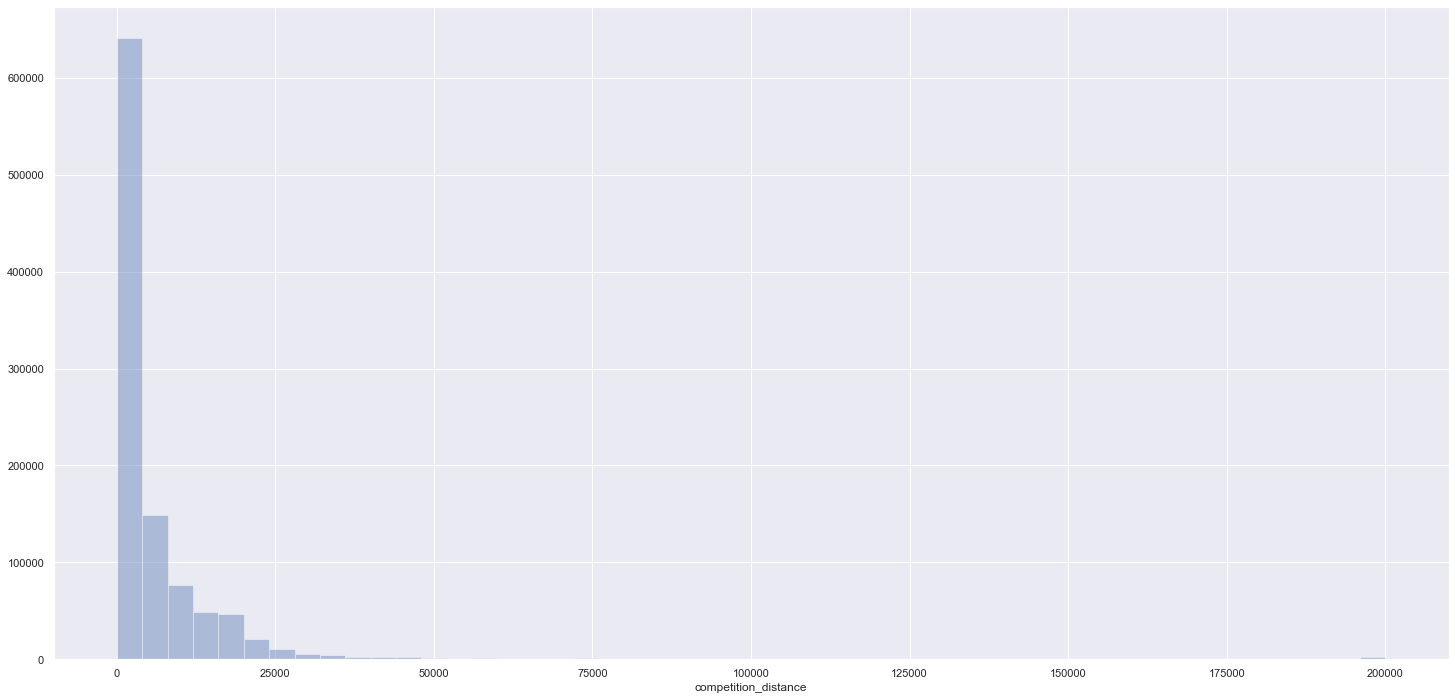

In [22]:
sns.distplot(df1['competition_distance'],kde=False);



## 1.7.2 Categorical Attribute

In [24]:
# unique = unico, ou seja ele pega todo mundo do DF1 ou de toda uma lista(como fosse uma soma)

# shape = forma: serve para vê todos os itens (somado) do DF ou da lista

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

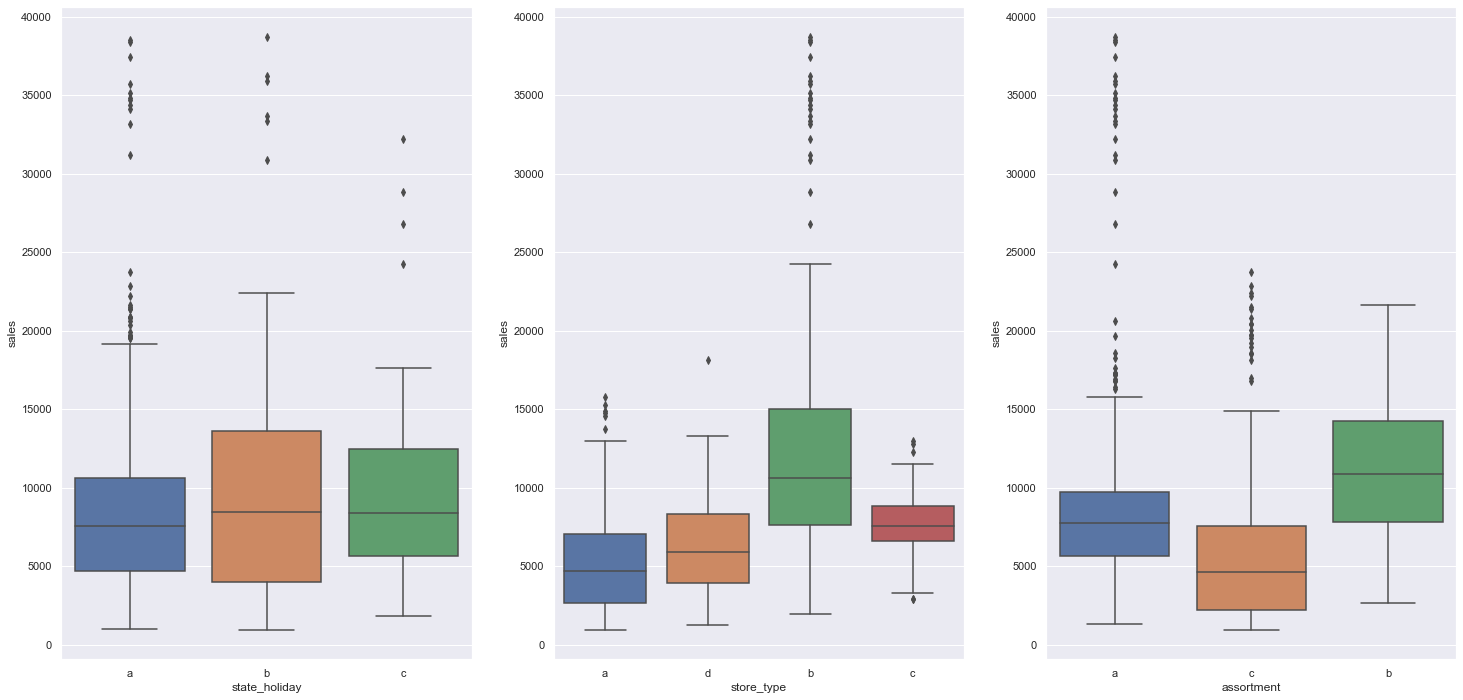

In [20]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales']> 0)]


plt.subplot(1,3,1)
sns.boxplot (x='state_holiday', y='sales',data=aux)
## no feriado b tem mais vendas do que no feriado A e C

plt.subplot(1,3,2)
sns.boxplot(x ='store_type',y='sales',data=aux)
#no tipo de loja, a loja b tem mais vendas que as demais lojas

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)



# 2.0 Passo 02- Feature Engineering

In [25]:
df2 = df1.copy()


#Converta a célula em markdown:

#pressionando M na célula selecionada OU Na barra de menus, Célula> Tipo de célula> Remarcação.
#( Observação: é importante converter a célula em Markdown, caso contrário, a opção "Inserir imagem" na etapa 2 não estará ativa)
#Agora vá para a barra de menus e selecione Editar -> Inserir imagem.

#Selecione a imagem do seu disco e faça o upload.

#Pressione Ctrl+ Enterou Shift+ Enter.

#Isso fará com que a imagem faça parte do caderno e você não precisará fazer o upload no diretório ou no Github. Sinto que isso parece mais limpo e não propenso a problemas de URL corrompidos.

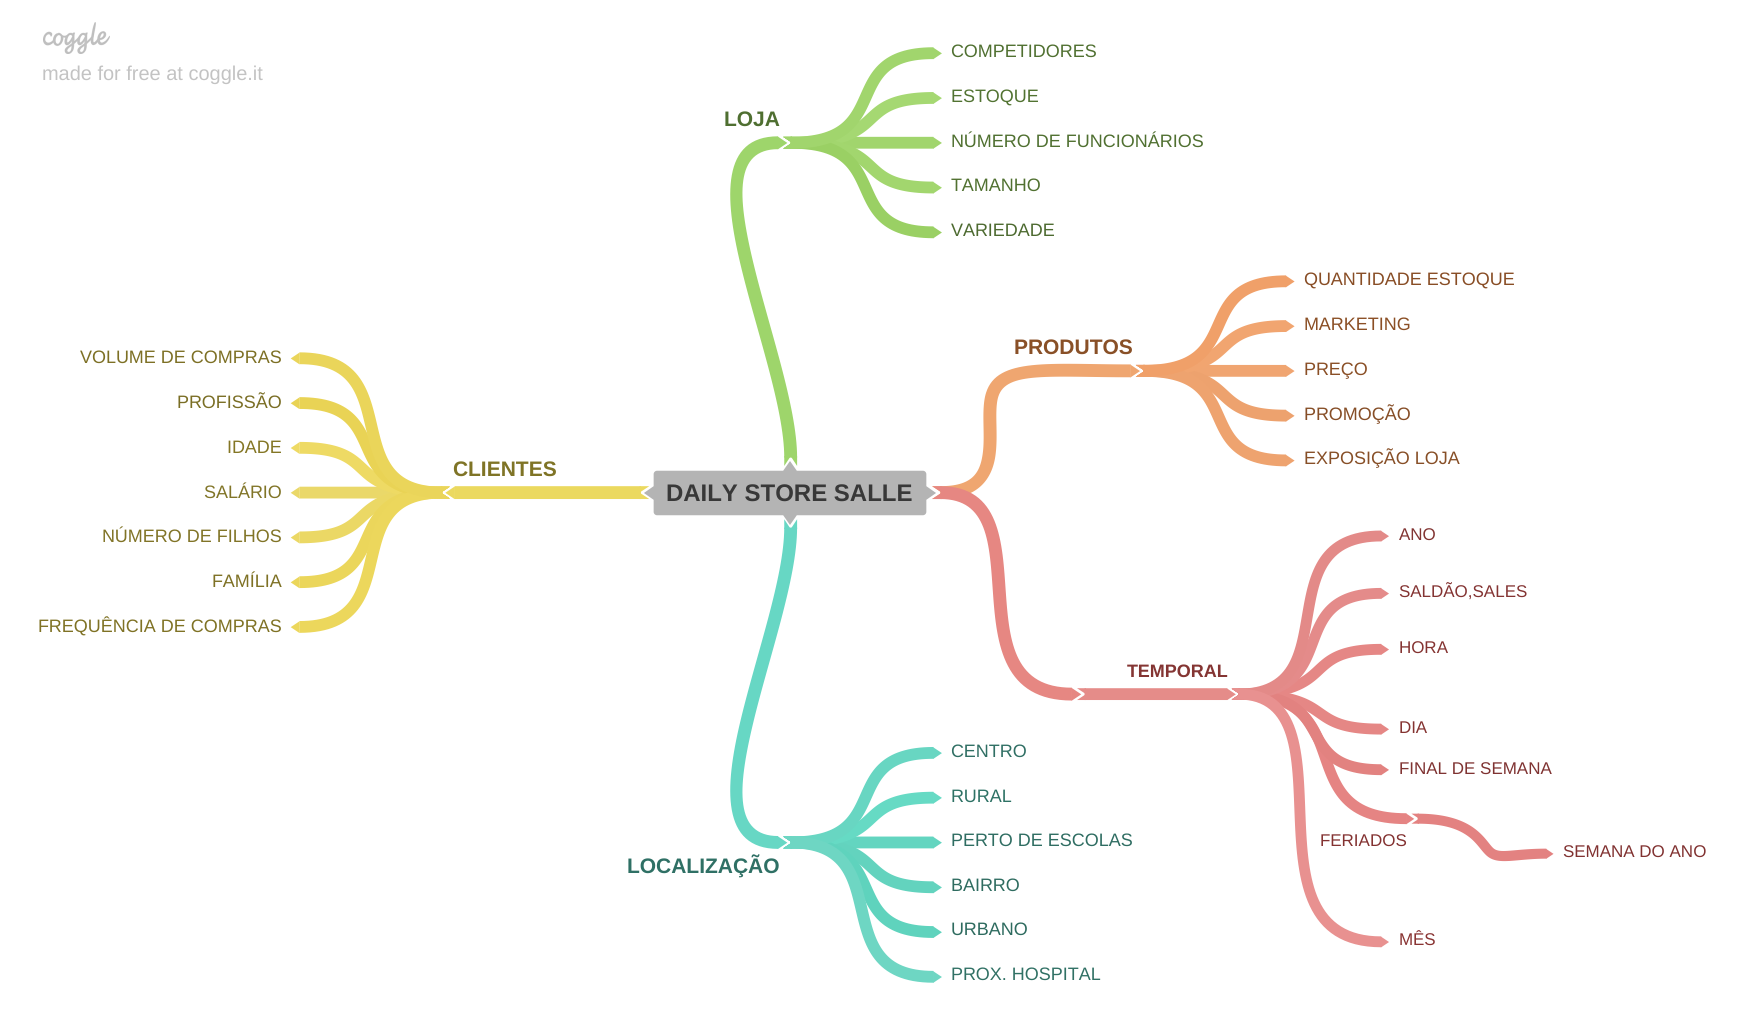


# 2.2 Criação das Hipóteses 

## 2.2.1. Hipótese Loja

**1.**  Lojas com número maior de fúncionários deveriam vender mais.

**2.**  Lojas com maior variedades de produtos deveriam vender mais.

**3.**  Lojas com maior porte deveriam vender mais.

**4.**  Lojas com maior capacidade de estoque deveriam vender mais.

**5.**  Lojas com competidores mais próximo deveriam venderiam mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

## 2.2.2 Hipótese Produtos

**1.** Lojas que fazem mais ação de marketing deveriam vender mais.

**2.** Lojas com mais  exposição dos seus produtos deveriam vender mais.

**3.** Lojas que ativam promoções por mais tempo deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com mais de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais. 

**7.** Lojas que tem preços mais baixos deveriam vender mais. 

**8.** Lojas com mais produtos em estoque deveriam vender mais. 

## 2.23 Hipótese Temporal

**1.** Lojas abertas no feriaodo de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos. 

**3.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

**4.** Lojas deveriam vender menos aos finais de semana. 

**5** Lojas deveriam vender mais no segundo semestre do ano.

**6.** Lojas deveriam vender menos nos feriaods escolares. 



# 2.3 Lista Final de Hipótese 

 **(essa lista eu considero os itens que eu tenho dados para fazer exploração dos dados)**


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


# 2.4 Feature Engineer

In [26]:
# site com explicação total sobre os métodos de tempo (time e timedelta/ date)
# https://www.guru99.com/date-time-and-datetime-classes-in-python.html
# https://www.geeksforgeeks.org/python-datetime-timedelta-function/ (ESSE EXPLICA COM MAIS DETELHAS O MÉTODO TIMEDELTA)
# https://miguendes.me/how-to-use-datetimetimedelta-in-python-with-examples (EXPLICAÇÃO MAIS DIDÁTICA DO TIMEDELTA)
df2['year']= df2['date'].dt.year

df2['month']= df2['date'].dt.month

df2['day']= df2['date'].dt.day

df2['week_of_year']= df2['date'].dt.weekofyear

df2['year_week']= df2['date'].dt.strftime('%Y-%W') #coluna criada para formatar data como"ano e semana desse ano".

#competition_since

# somando as duas colunas de competition year e week para ter a media em dias. Para isso foi necessário conventer em datas.
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

##tempo de competição em meses. (subtraindo  coluna de datas com coluna competition_since que foi transformada tbm em data)
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int)

#promo_since

#primeiro deve transformar as duas colunas em strings para unir as datas
df2['promo_since']= df2['promo2_since_year'].astype( str) + '-' + df2['promo2_since_week'].astype( str )
# depois aplicar a formula lambda para transoformar string em datas para serem formatatos na mesma coluna(ano,semana,numero)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
# essa parte é como a dos meses. Para transformar as semana em dias (inteiros)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype (int )

##assortment (a = basic, b = extra, c = extended) - objetvo aqui é mudar letras para descrição completa no DF.

# racicionio lamda: "argumento(x) if(se) x(argumento é igual a comparação(resultado))
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x =='b'else 'extended')

#State_holiday a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


<ipython-input-26-894951c22689>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']= df2['date'].dt.weekofyear


In [19]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VÁRIAVEIS

In [27]:
df3 = df2.copy()
# nesse passo vamos excluir os dados irrelevantes para podemos explorar o que realmente é essencial
# então temos que analisar todos as possíveis restrições do projeto 

## 3.1 Filtragem de Linhas

In [28]:
#coluna open representa lojas abertaa, ou seja, loja aberta tenho venda, fehcado não. Então não tenha dado
# colunas "sales" são as vendas das unidades. Ou seja preciso de apenas vendas que são maiores que "0". tenha ao menos 1 venda


df3 = df3[(df3['open'] != 0) & (df3['sales'] >0)]


## 3.2 Seleção das Colunas

In [29]:
cols_drop= ['month_map','customers','promo_interval','open']

## fazendo dessa forma cria uma lista com as colunas que não há necessidade. 
#quando for remover com o método "x".drop (nome das colunas, a partir de qual) vai procurar e excluir as colunas com esses nomes


In [30]:
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANÁLISE DE EXPLORATORIO DOS DADOS

In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada 
  ##### tem o objetivo de olhar unicamente a váraivel (se é uma max, min, média,mediana, range)

## 4.1.1 Responde Variable

C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


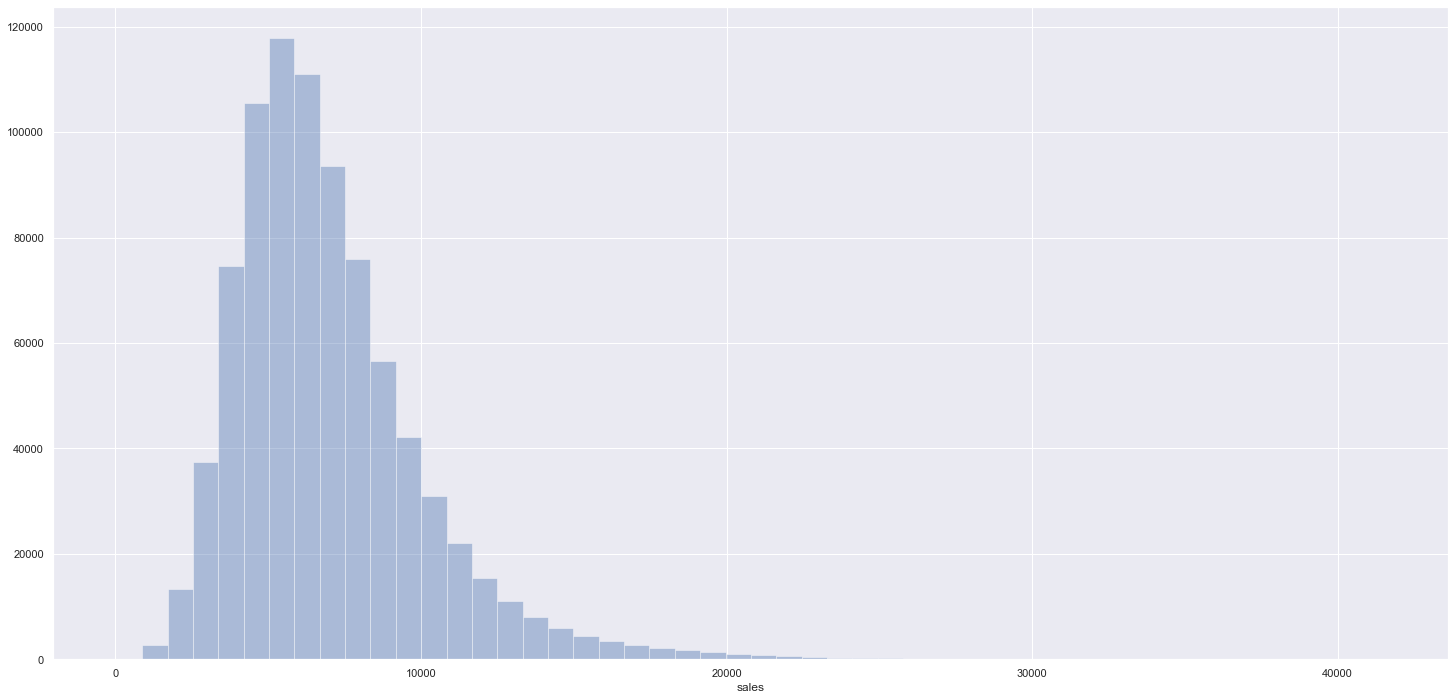

In [23]:
sns.distplot(df4['sales'], kde= False);

# explicação histograma https://ferramentasdaqualidade.org/histograma/

## 4.1.2 Numerical Variable

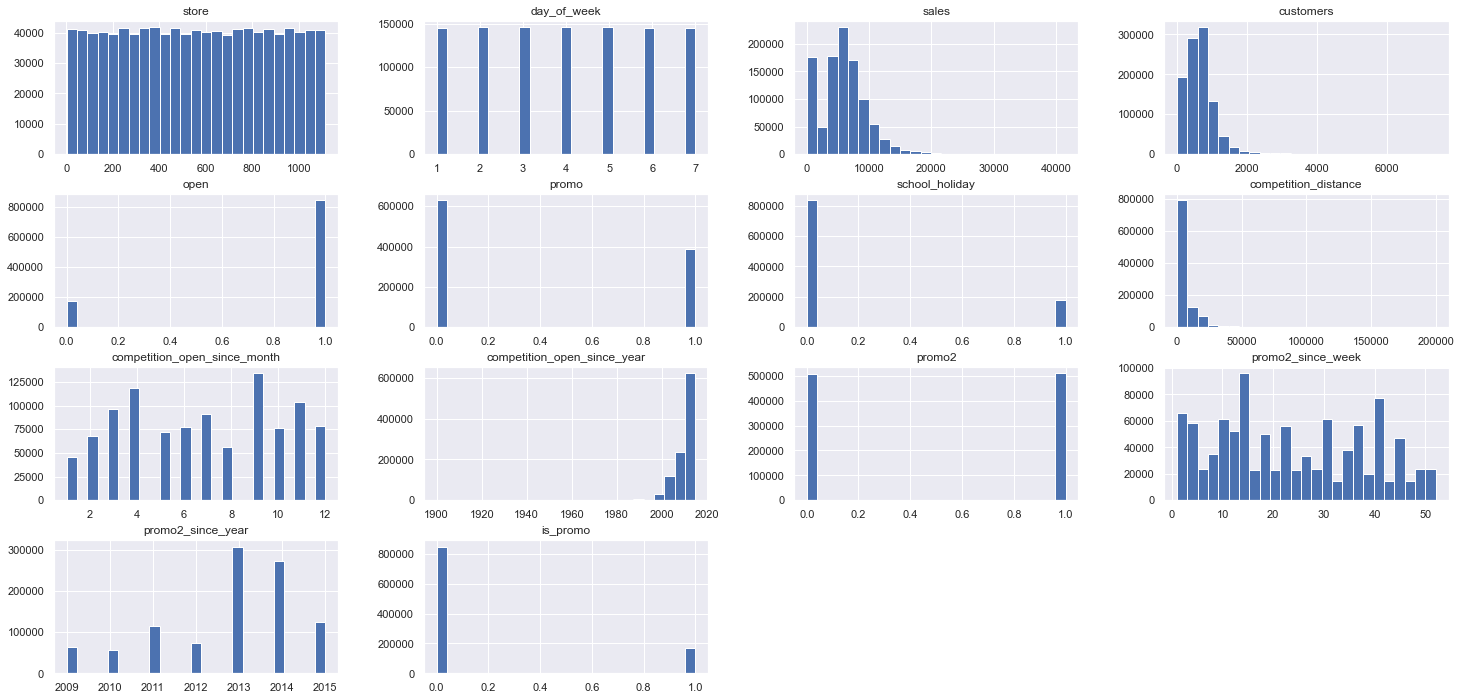

In [33]:
num_attributes.hist(bins=25);

## gráfico das váriavéis coletadas e tratadas anteriomente. 
#objetivo dessa parte é analisar as váriaveis e reparar diferenças e com isso gerar insight posteriores. Vê as correlações dos fenômenos
# Com isso poderá muitas das vezes quebrar algumas crenças nas equipes das empresas, onde baseiavam-se no "achismo" das operações.


 ### análise em uma setença nos gráficos. 

1º gráfico - store: É um gráfico platô. Ou seja que indepedente dos números de lojas não há uma correlação com as vendas. Nem aumenta ou diminui. 

2º gráfico - day_of_week: A vendas das lojas indepedente do dia da semana são as mesmas. Não há nenhum pico de maior ou menor venda em dias diferentes.

3º gráfico - sales: Nesse gráfico é possível verificar que é um gráfico assimetrico. Em outras palavras há íncio de vendas proximoa 0 e uma eleação ao decorrer das vendas e posteriomente vai diminuindo.

4º gráfico - Customers: há um grande pico de clientes no começo das vendas, entre tanto, depois há um queda costante de entrada de clientes. Possívelmente
há alguma relação com abertura de lojas, onde há uma novidade e depois de um período tende a diminuir com normalidade. 

5 gráfico - Open : Quanto mais loja abertas maior a quantidade vendas. Ou seja, quanto mais próximo do 1 que representa uma loja aberta mais vendas tenho nesse evento. O inverso como esperado acontece quanto fica mais próximo do 0, menor a minha quantidade venda, pois a loja está fechada. 

6º gráfico - promo : Neste gráfico é possível verificar que é algo supreendente. Ele aponta que há um maior número de vendas quando não é feito promoção. 

7º gráfico - school holiday - Como era esperado a ausência de feriado escolar impacta em um maior número de vendas. Como apontado no gráfico, no frequencia 0. 

8º gráfico - competition_distance - Neste gráfico é possivel verificar o comportamento das vendas das lojas em relação a aberturas de novas lojas(competidores). O gráfico aponta então um aumento de vendas em relaçao a cada 4 meses e a cadas 10 meses de novos competidores

9º gráfico - competition_since_month : referente abertura de lojas não há uma definição certa de acordo com o gráfico. Há uma aleotoriedade nas aberturas de lojas em relações as vendas. É uma gráfico de aletoriedade. 

10º gráfico - competition-since_year: observando o gráfico é possível indentificar que houve uma elevação constantante nas vendas a partir do anos 2000 com abertura de novas lojas. Ou seja a nos últimos 20 anos houve um aumento consideravel. 

11º gráfico - promo2 : Nesse gráfico onde representa a continuidade dos competitores com as promoções feita anteriomente, aponta que há o mesmo nível de vendas entre os competidores. Ou seja, o prolongamento das promoções não representa um maior número de vendas. Ou seja há dois picos iguais (histograma com dos picos). 

12º gráfico - promo2_since_week: Neste gráfico há inúmeras variações de vendas ao decorrer das semanas. A continuação da promoções não seguem um padrão. Ou seja é um gráfico de histograma de aletoriedade. 

13º gráfico - promo2_since_year : é possível detectar que as continuaçãoes das promoções tiveram um melhor desempenho nos anos de 2013 e 2014. 

14º gráfico - is_promo: nesse gráfico onde simboliza se a uma loja está fazendo alguma promoção naquele dia, há outro dado no mínimo intrigante. Com esse gráfico é possível verificar que as lojas que estão fazendo uma promoção naquele dia (1) teve um número de vendas muito menor do que as lojas que não estavam fazendo no mesmo dia. 

## 4.1.3 Categorical Variable
 ##### transformando váriaveis de texto (strings) em váriaveis númericas

In [32]:
cat_attributes.head()

#nessa etapa é interessante fazer essa análise para sabemos qual tipo de feriado há mais impacto em relação as vendas. 
#então vamos descobrir quantas linhas (podemos entender como volume) há mais frequência. 


,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [33]:
df4['state_holiday'].drop_duplicates()

#esse total numérico representa o volume de vendas das lojas. Como visto regular_day (dia útil) é 0, pois é um dia comum de trabalho.

#fonte p/ entender o gráfico. 
# https://medium.com/@gisely.alves/visualiza%C3%A7%C3%A3o-de-dados-com-seaborn-2fd0defd9adb
# https://learndataeveryday.com/02-aprenda-estatistica-com-python-analise-categorica/#:~:text=O%20nome%20desse%20m%C3%A9todo%20%C3%A9,'%2Cdata%3Ddataframededados).

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

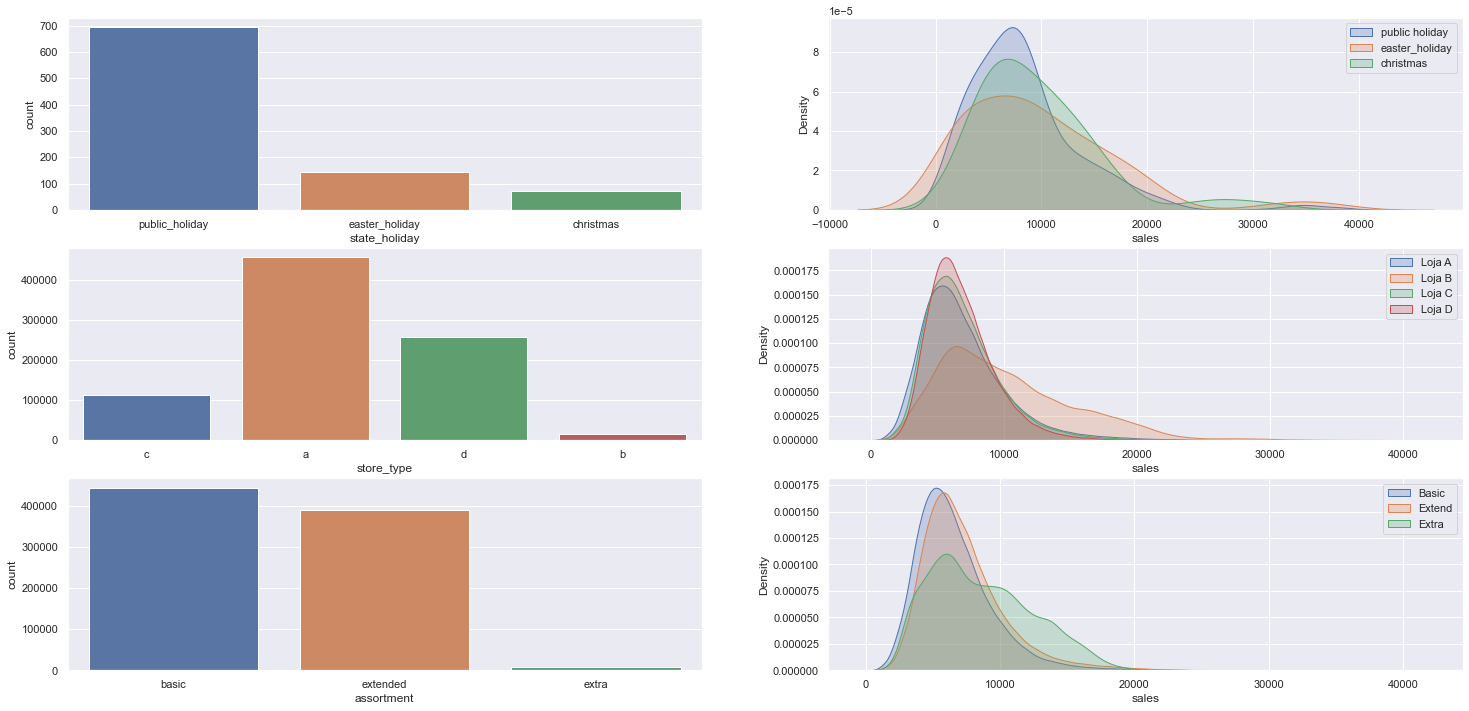

In [36]:
#fonte conceito subplot =http://www.estruturas.ufpr.br/disciplinas/pos-graduacao/introducao-a-computacao-cientifica-com-python/introducao-python/3-2-figuras-subplotagens-eixos-e-marcadores/
#https://paulovasconcellos.com.br/15-comandos-de-matplotlib-que-talvez-voc%C3%AA-n%C3%A3o-conhe%C3%A7a-17cf88a75119
#https://www.acervolima.com.br/2020/05/adicionando-legendas-ao-grafico-com.html

#state_holiday
plt.subplot(3,2,1)
# a lógica do subplot é dessa forma: "linha,coluna, imagem". 
a= df4[df4['state_holiday']!= 'regular_day'] #lógica: meus feriados estuados são menores que meus dias regulares de trabalho(isso é um filtro)
sns.countplot(a['state_holiday'],label= 'Comparativo de feriados')
#nesse gráfico de count é utilizado para contabilizar categorias(GÊNERO DE PESSOAS H E MULHERES) ao invés de contabilizar intervalo de valores(EXEMPLO IDADE 0 A 10)
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label = 'public holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label = 'easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade=True)
plt.legend(loc='best') #legenda no gráfico/ colocando ela no melhor lugar

#store_type:
plt.subplot(3,2,3)
sns.countplot(df4['store_type'],label='Tipos de Lojas')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'],label='Loja A',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='Loja B',shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label = 'Loja C',shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label= 'Loja D',shade= True)
plt.legend(loc='best')

#assortment (diversidade)
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label ='Basic',shade= True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='Extend',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label= 'Extra',shade=True)
plt.legend(loc='best')

# Descrição em uma frase sobre os gráficos!

### https://medium.com/turing-talks/turing-talks-9-visualiza%C3%A7%C3%A3o-de-dados-93df670d479 (INTEPRETAR GRÁFICOS)

1º linha de gráficos: No que refere as tipos de feriados que ocorrem as vendas das lojas é possível indentificar no gráfico de barras que os feriados públicos tem um maior volume de vendas. é possível deduzir esse volume maior pois trata-se de um vários tipos feriados. A seguir temos como Esater (Páscoa) e Natal como terceiro lugar nesse volume. Mas ao olhamos o gráfico de sombra é possível indentificar que apesar de o feriado de "Easter" ter volume maior nas vendas em comparação ao feriado de Christimas é possível obsvar um pico maior nas vendas dos Christmas em relação ao Easter. 

2º linha Gráfico: Os tipos de lojas que são analisados nesse projeto é possível indentificar que a loja do tipo A é a lider de vendas entre os quatros tipos de lojas. Seguindo em segundo lugar a loja do tipo C, terceiro em venda sendo loja do tipo D e por último B. Mas é possível indentificar no gráfico de sombra que a loja D tem picos de vendas menor entre todas as quatros tipos de lojas. E os quatros três tipos de lojas é possível verificar que os picos de vendas são bem próximos. 

3º linha Gráfico: No tocante do gráfico de assortment(sortimentos) dos produtos nas lojas, é possível tanto no gráfico de barros por volume como no gráfico de são correspondentes em volumes e picos das vendas. 

# 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA**:

Lojas que com maior sortimento vendem menos. 


<AxesSubplot:xlabel='year_week'>

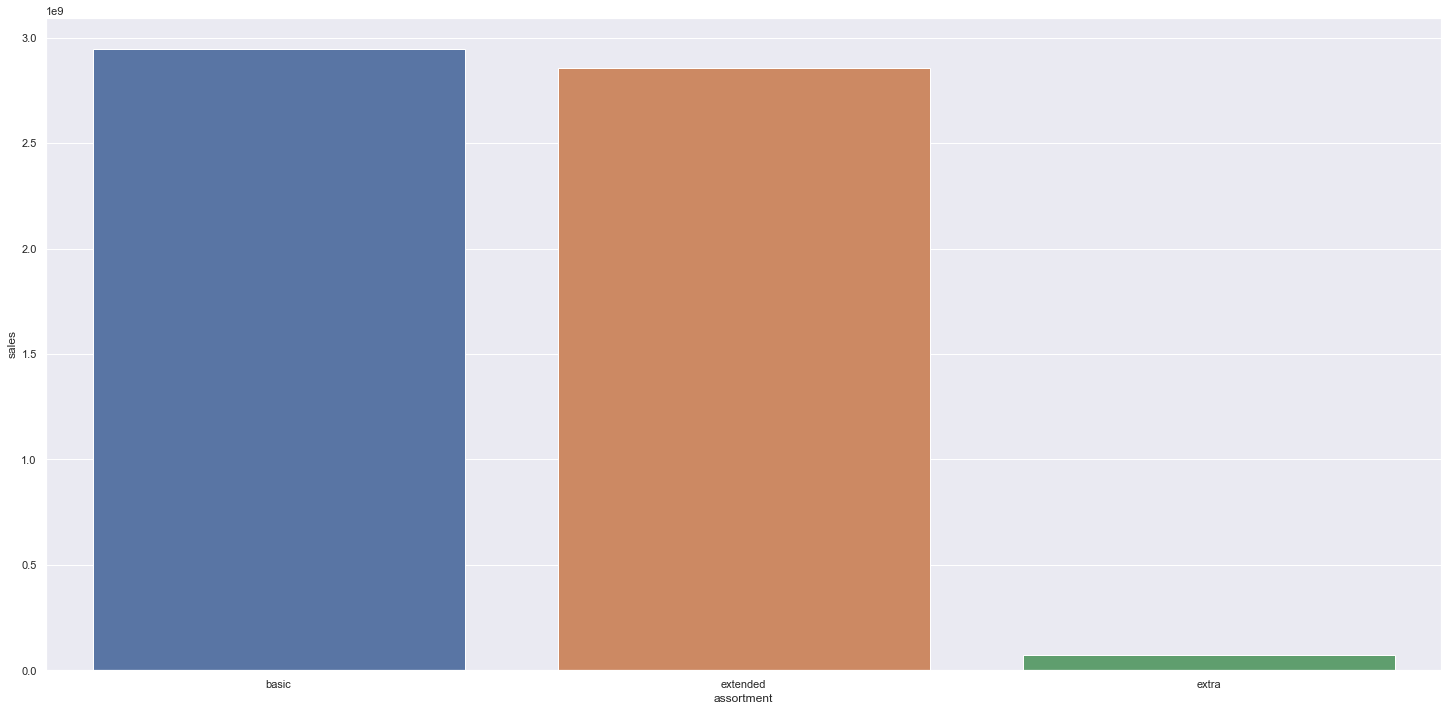

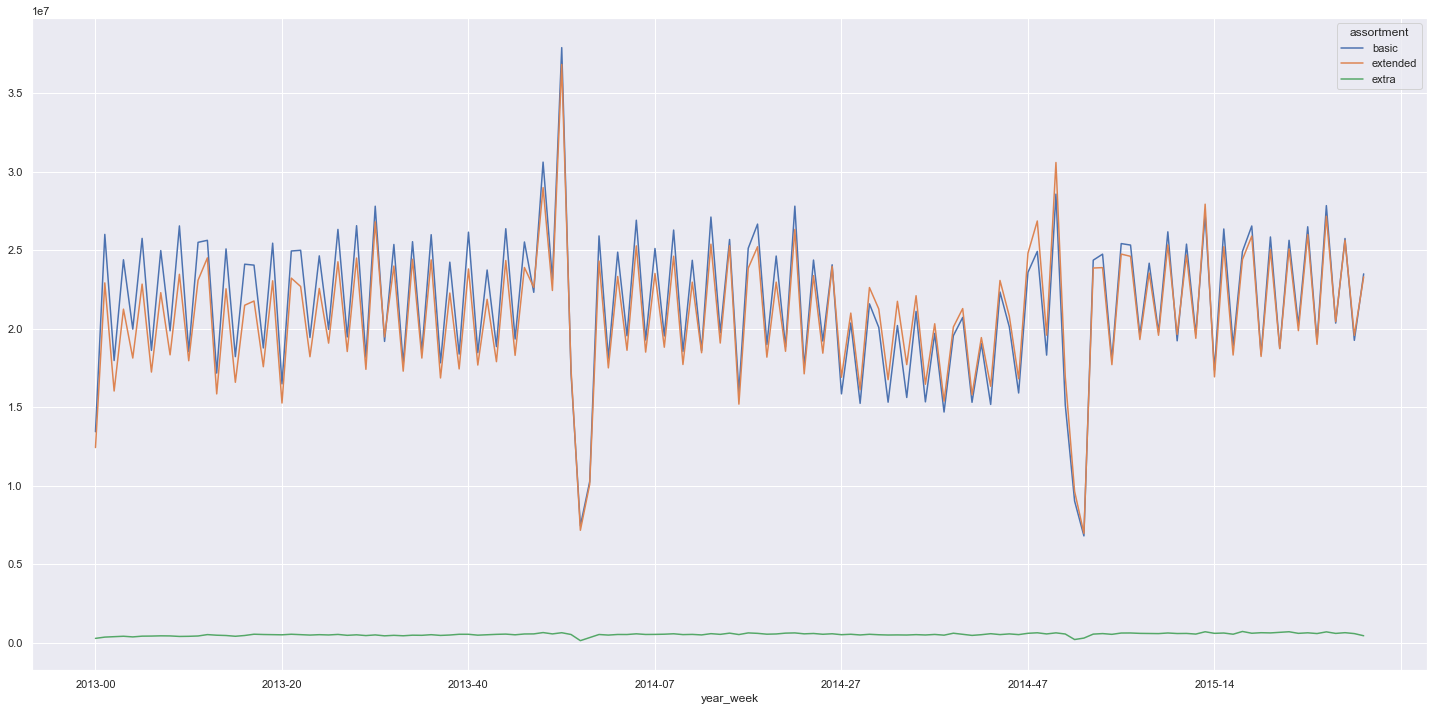

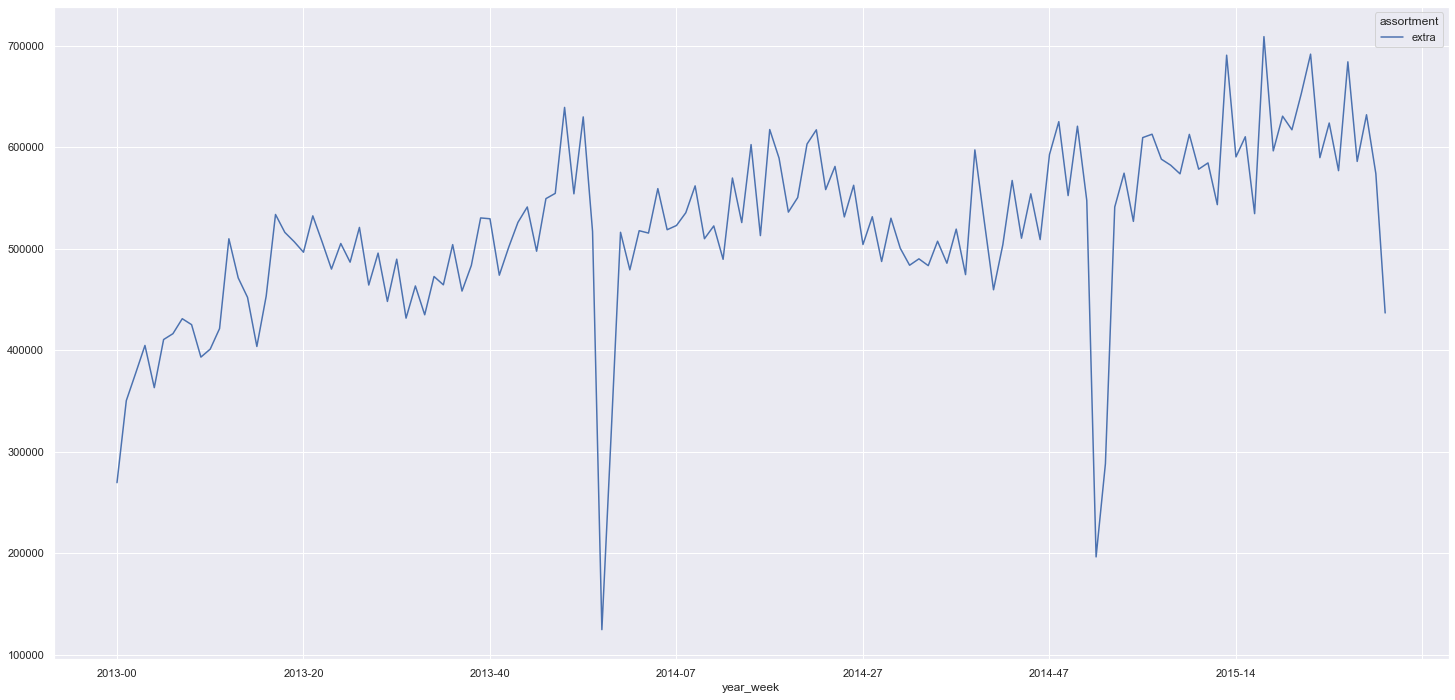

In [46]:
# resert_index reclassifica os índices (https://www.delftstack.com/pt/howto/python-pandas/pandas-reset-index-python/)
# método groupby : "separaa os valores dos dados por tipo - ex: valores médio dos imóveis por bairro e não o valor médio de todos imóveis"
#link groupby: https://cursos.alura.com.br/forum/topico-uso-do-groupby-112111


aux1= df4[['assortment','sales']].groupby('assortment').sum().reset_index() #esse é o filtro: estou separando por grupos o total de assortment
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

# entre tanto esse volume total de vendas entres os tipos de produtos não representam um comportamento ao longo do tempo
# existe há possibilidade de ao decorrer do tempo o volume de vendas do produto "EXTRA" tem tido queda por um período de tempo

aux2 = df4[['year_week','assortment','sales']].groupby(['assortment','year_week']).sum().reset_index()
#função pivot = para organizar em indíces (linhas), colunas e valores(números)
aux2.pivot(index ='year_week',columns = 'assortment',values ='sales').plot()

#olhar linha separadamente (quando houver diferença gritante- sempre olhar a magntude do eixo Y(valores))- então fazer um filtro do filtro
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index ='year_week',columns ='assortment',values ='sales').plot()

## Análise gráfico simples: 

Análise 1º gráfico: Após separamos or grupos os "assortments" é possível indentificar que a soma das vendas por categoria nas lojas. Já no primeiro gráfico é possível ver que os produtos dos tipo Extra contém vendas muitos inferiores a outros dois tipos. Mas é sempre válido olhar o gráfico ao deccorer do tempo para saber se é um comportamento típico do produto ou foi algo sazonal. 

Análise 2º gráfico : Neste segundo gráfico de semana dos anos é possível verificarm que os produtos basic e extended tem vendas muitos semelhantes ao decorer dos anos. Pois como aponta o eixo Y os valores são muuitos próximos. Ao contrátrio do Extra fica com valores muito abaixo em relação aos outros dois tipos que tem vendas com muito com mais volumes. 

Análise 3º gráfico:Com este terceiro gráfico plotado é possível verifica um comportamento diferente do que aparentava em relação ao segundo gráfico, em que as vendas do EXTRA parecia mais linear. Com separação em gráfico EXTRA é possível vê que ao decorrer do tempo ele contém vários picos de vendas. 



### H2. Lojas com competidores mais próximos deveriam vender menos.




***Falso***

Lojas com competidores mais próximos vendem mais

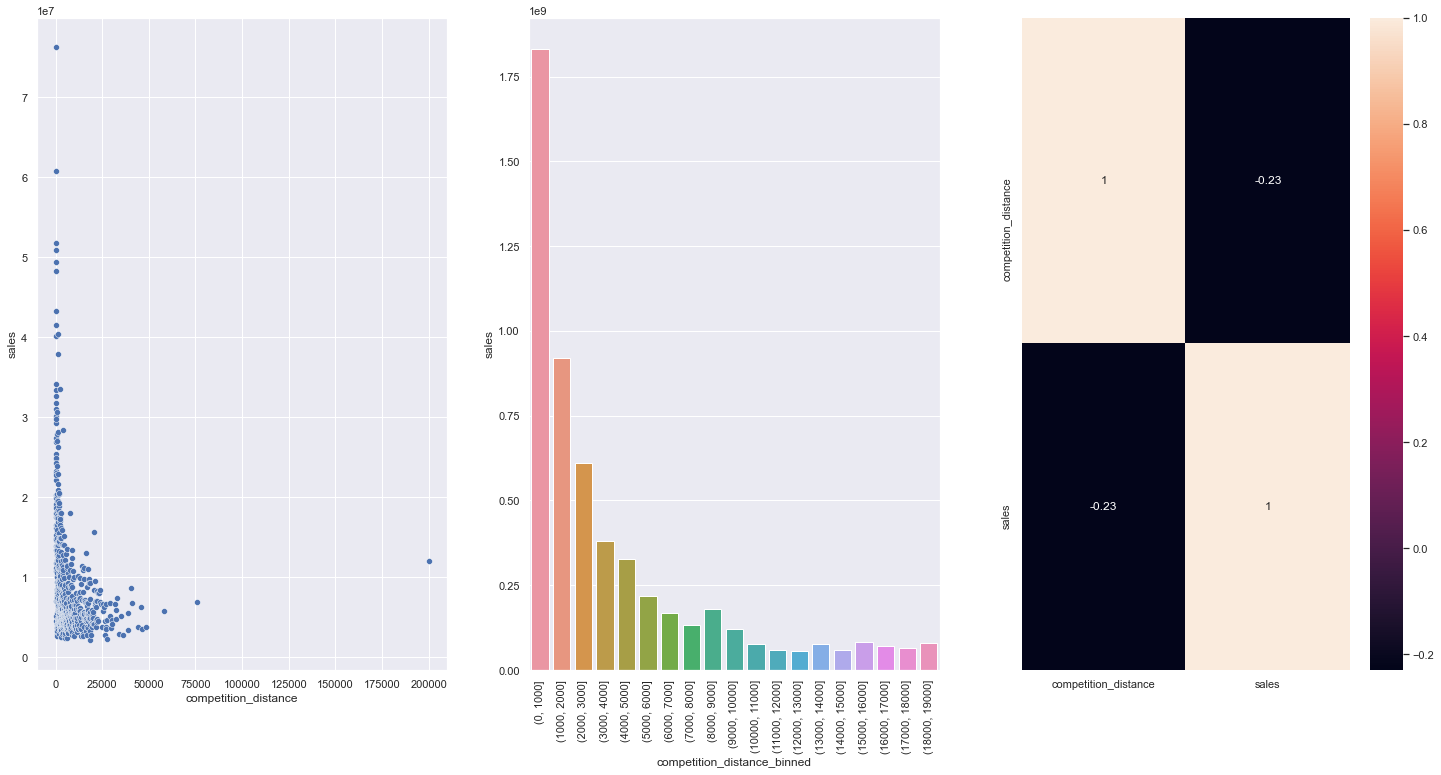

In [46]:
# https://www.fm2s.com.br/grafico-de-dispersao/ (sobre gráfico de dispersão/scatter)
# é um gráfico para estudar correlações

plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index() #nessa linha é separado por distancia da loja em relação
# as vendas dessas lojas
sns.scatterplot(x = 'competition_distance',y='sales',data =aux1); #gráfico de dispersão

plt.subplot(1,3,2)
#https://appdividend.com/2019/01/31/numpy-arange-tutorial-with-example-python-numpy-functions/ (explicndo np.numpy)
#https://www.vooo.pro/insights/conceitos-python-arange-e-linspace/ (conceito np.numpy)
bins = list(np.arange(0,20000,1000)) #aqui estou transformando ele em lista e usando np.arange para separar a cada 1000 metros

#https://cursos.alura.com.br/forum/topico-funcao-cut-e-categorizacao-intervalar-125799 - sobre pd.cut
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins) #aqui estou colocando a distancia das lojas em caixote
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y= 'sales', data= aux2);
plt.xticks(rotation =90);

#https://italocegatta.github.io/os-graficos-que-explicam-nossos-dados-heatmap/ -mapa de calor
#https://italocegatta.github.io/os-graficos-que-explicam-nossos-dados-heatmap/ - gráfico de calor

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method ='pearson'),annot= True); #medindo a força da correlação das vendas c/distância
#https://medium.com/@gisely.alves/visualiza%C3%A7%C3%A3o-de-dados-com-seaborn-2fd0defd9adb


# Descrições dos Gráficos:

1º gráfico - dispersão: Neste gráfico é possível averiguar que há uma concetração de vendas entre as lojas mais próximas. 

2º gráfico - gráfico de barras : Foi feito uma separação nesse gráfico entre grupos de lojas a com distância a cada 1000 metros. Com isso foi possível indentificar a queda de vendas conforme a distância de uma loja para outra. Conforme mais longe menos essas lojas deste grupos distantes vendiam. 

3º gráfico - gráfico de heatmap(calor) : Com esse gráfico usando o método "corr" foi possível medir a força da correlação entre vendas e a próximidades entre a distância de competidores.  



### H3. Lojas com competidores à mais tempo deveriam vendem mais.

***FALSO:*** Lojas com competidores mais tempo não vendem mais. 

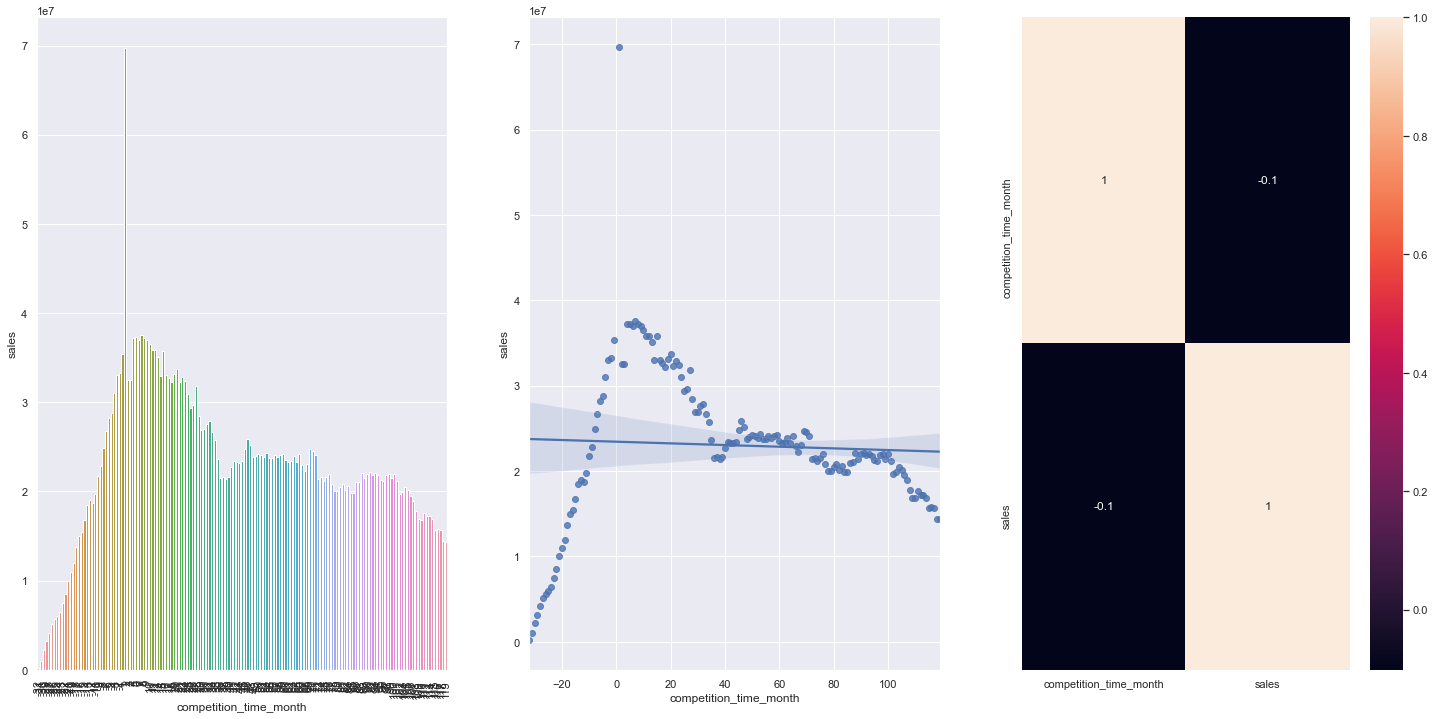

In [29]:
plt.subplot (1,3,1)
auxh1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index() #transforma em um novo DF. 
auxh2 = auxh1[(auxh1['competition_time_month'] <120) & (auxh1['competition_time_month'] != 0)] #filtro
#esse filtro tem como objetivo  verificar o tempo de lojas (que estão em meses) abaixo de 120 meses.

sns.barplot(x='competition_time_month',y='sales',data = auxh2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x ='competition_time_month', y = 'sales',data = auxh2);

plt.subplot(1,3,3)
sns.heatmap(auxh1.corr (method = 'pearson'), annot = True);

# Análise dos Gráficos

1º gráfico : Nesse gráfico de barras é possível indentificar que nesse período de 120 meses no ínicio há uma elevação das vendas, entre tanto esse pico tem  uma queda ao decorrer dos meses. 

2º gráfico : nesse gráfico de regplot é possível vê que há uma semelhança nas vendas e com íncio de quedas.

3º gráfico : nesse gráfico de sombra com coeficiente da correlação é totalmente afirmar que não há uma correlação do tempo de competidores em relações as vendas. 

# H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

***FALSO:**** Lojas que tem promoções ativas(extendidas) por um período de tempo maior não vendem mais.

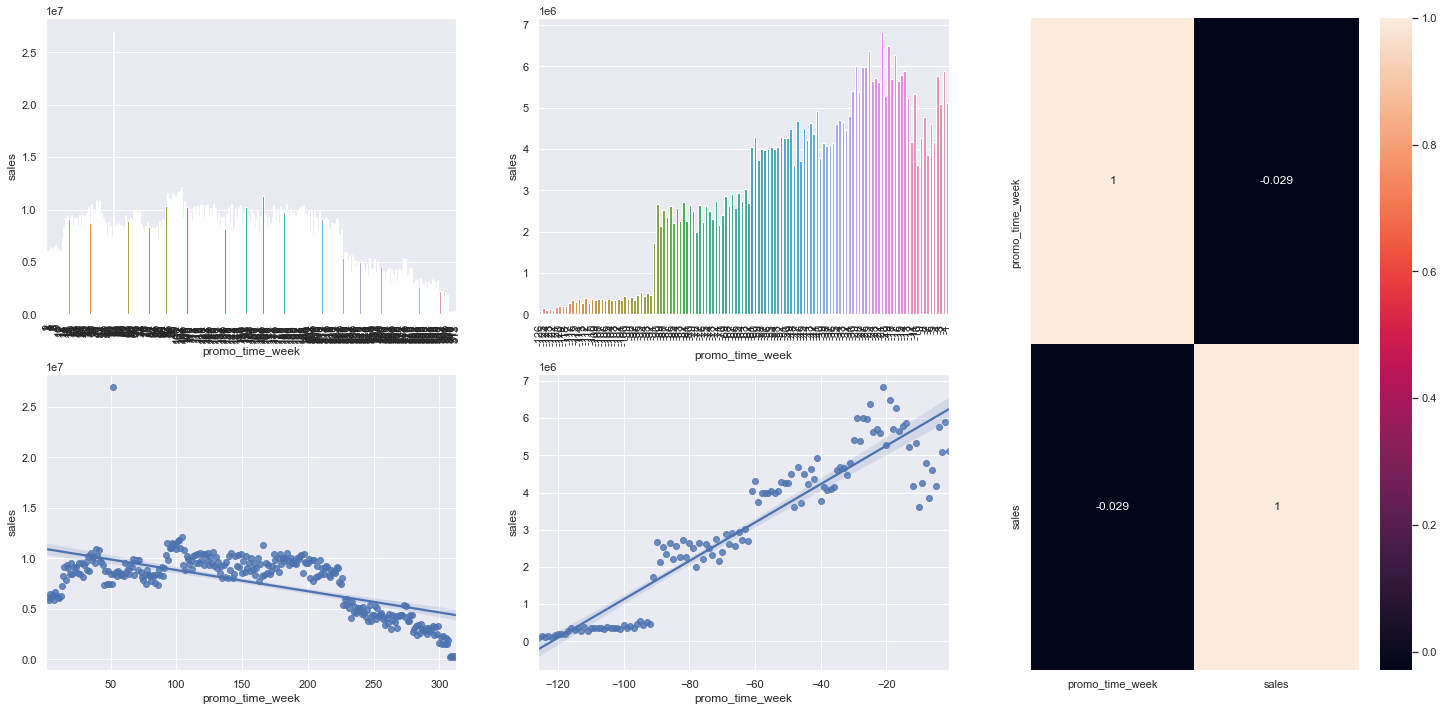

In [30]:
# aqui coloquei no primeiro momento por ano, mas por semana é possível vê melhor o comportamento dessa váriavel ao decorrer do tempo)
# esse proceddo de filtro é para dar um "zoom" no arquivo e ter noção melhor do comportamendo das váriaveis. Mas para o modelo é todo promo_time_week

auxh4 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index() #montando um DF
#plotando direto o barlot não há como fazer a leitura do comportamento da promoção. Devido o grande volume de dados. 
#para isso é recomendável fazer um fitro desse grande volume de dados

grid = GridSpec(2 ,3)

filtro1= auxh4[auxh4['promo_time_week'] > 0] #promoção_extendida ou seja somente números positivos pois será no futuro.

#filtro2 = auxh4[auxh4['promo_time_week'] < 0] #promoção regular (dentro do planejamento de ofertas),ou seja valor negativo, pois não houve a extensão.
plt.subplot(grid[0 ,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = filtro1); #promoção_extendida / #gráfio de barras faz uma comparação de valores
plt.xticks(rotation=90);


plt.subplot (grid[1,0])                 
sns.regplot(x = 'promo_time_week', y= 'sales', data = filtro1);

plt.subplot(grid[0,1])
filtro2 = auxh4[auxh4['promo_time_week'] < 0] #promoção_regular / gráfico de barras faz uma comparação de valores
sns.barplot(x = 'promo_time_week', y = 'sales', data = filtro2);
plt.xticks(rotation=90);


plt.subplot(grid[1,1]) #gráfico de regplot demostra a tendência de uma váriavel. 

sns.regplot (x = 'promo_time_week', y = 'sales', data = filtro2);
            
#http://www.estruturas.ufpr.br/disciplinas/pos-graduacao/introducao-a-computacao-cientifica-com-python/introducao-python/3-2-figuras-subplotagens-eixos-e-marcadores/ 
# lógica do Grid: começa sempre no "0", então a lógica é linha e depois a coluna(ele monta uma espécie de grelha)
#gráfico de regplot pode ser entendido como um gráfico de tendência!

#mapa de calor
plt.subplot(grid[:,2])
sns.heatmap(auxh4.corr (method = 'pearson'), annot = True);

#auxh4.sample(7) 
# procurar saber o motivo de ser negativo.(resposta = a vendas negativas foram feitas antes da promoções serem extendidas(período tradicional).
# As positivas foram feitas após as promoções extendidas naqueles períodos começarem a ser executadas. 

# Análise dos Gráficos:

1º Análise: Fazendo um comparativo de valores com o gráficos de barras com o primeiro filtro onde é segmentado a extensão das promoções das lojas é observando em cojunto o gráfico de regplot, onde o objetivo é traçar a tendência dos valores é possível afirmar que essas promoções extendidas tem quedas ao decorrer das promoções que vão ser extendidas. 

2º Análise: Fazendo a mesma observação de leitura dos gráficos anterior, é possível verificar que as promoções regulares (valores negativos) tem elevação de vendas. É possível vê claramente nos gráficos de comparações de valores (barras) e gráfico de regplot(tendência).

E com isso é possível concluir e afirmar que as promoções extendidas(logo após o prazo tradicional) não surtam efeitos nas vendas. 

 # <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

# H6. Lojas com mais promoções consecutivas deveriam vender mais.

***FALSO:*** Lojas que tem mais promoções consecutivas não vendem mais. 


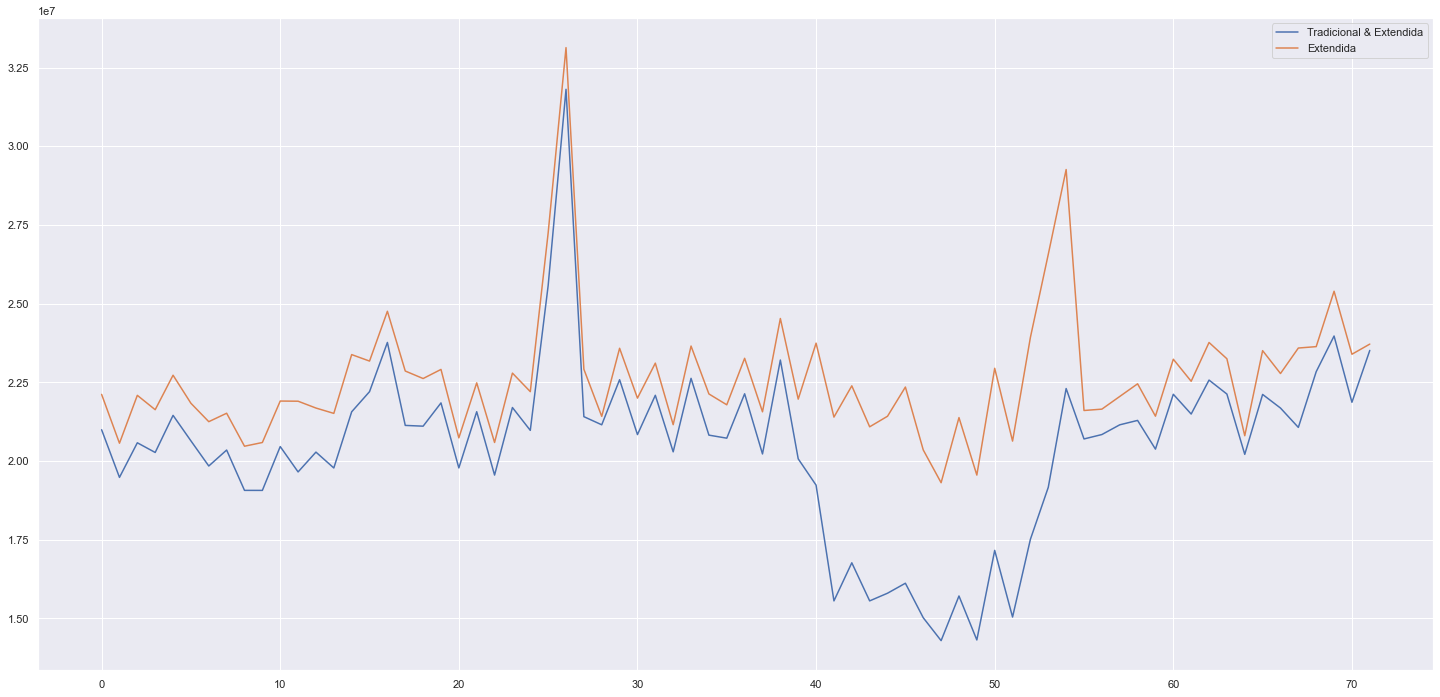

In [41]:
auxh6 = df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

filtro1 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
grafico1 = filtro1.plot();

#número 1 representa que é uma loja participante
#número 0 representa que não é uma loja articpante da promoção

filtro2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()

filtro2.plot(ax= grafico1);


grafico1.legend(labels = ['Tradicional & Extendida','Extendida']);


# Entendimento do gráfico:

***Análise:*** Após fazer um filtro sobre os tipos de promoções ('Promo" = Tradicional e "Promo2" como Promoção extendida da tradicional) foi possível verificar que com o gráfico traçando uma linha do tempo que tanto as promoções tradicionais (Promo) assim como as Extendidas (Promo2) tem u comportamento de vendas muito semelhantes. Então através desse dado é possível afirmar que as promoções extendidas nas lojas particpantes não afetam positivamente as suas vendas. 

# H7. Lojas abertas durante o feriado de Natal deveriam vender mais

**Falso:** Lojas que abrem no feriado de Natal não vendem mais. Elas vendem menos

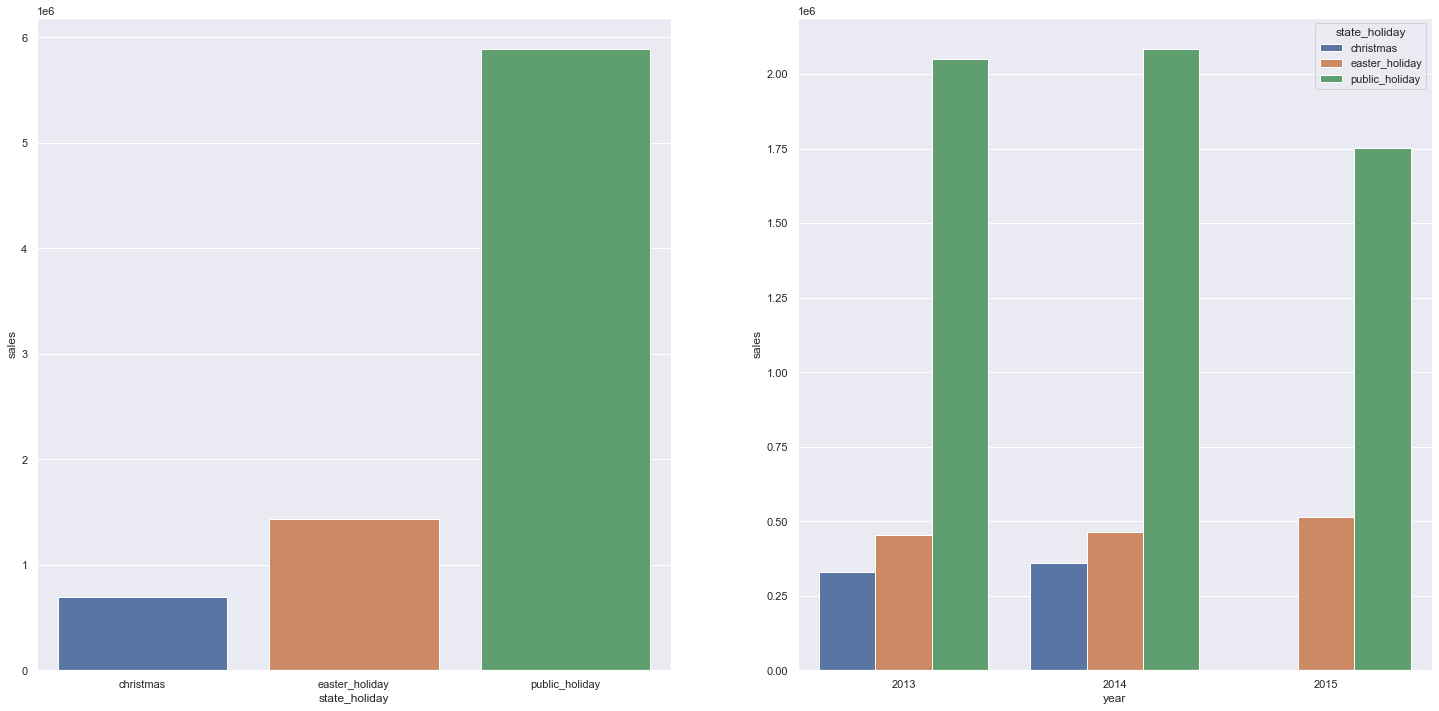

In [65]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(x = 'state_holiday',y= 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()

sns.barplot(x = 'year', y= 'sales', hue = 'state_holiday', data= aux2);

#procuar saber o que é "hue"
#resosta = hue sere para add um tereiro elemento em uma váriael. 
#christmas

****DESCRIÇÃO DOS GRÁFICOS:*** É possível análisar tanto pelo primeiro gráfico onde seleciona as vendas dos grupos de feriados, como no segundo que classifica as vendas em anos (year) que as lojas que abrem e fazem venda no dia de Natal (Christimas) não vendem mais do que os outros feriados Pelo contrário, os dados apontam que são as lojas que menos vendas em relações as demais.

# H8.  Lojas deveriam vender mais ao longos dos anos.

***Falso:** Loja vendem menos aos longos dos anos. 

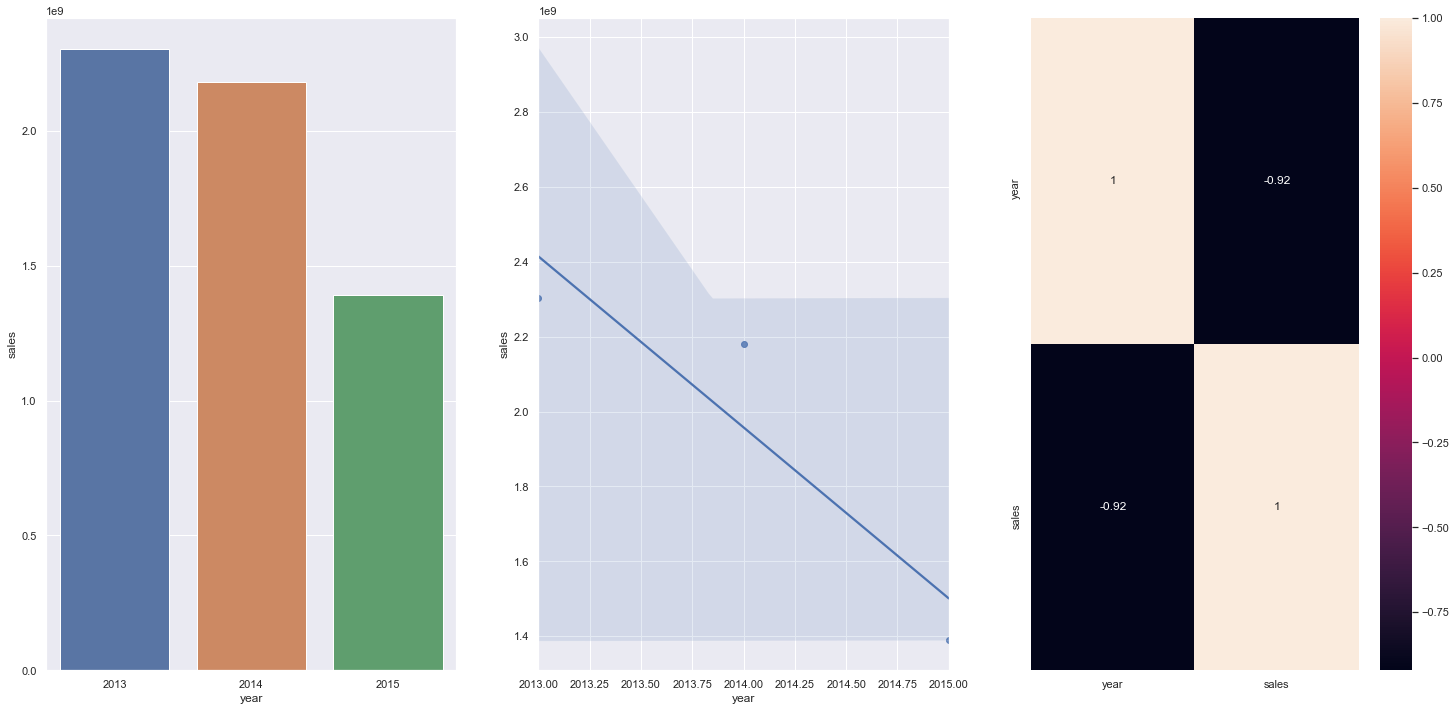

In [44]:
auxh8 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = 'year' , y = 'sales', data = auxh8);

plt.subplot(1,3,2)
sns.regplot( x = 'year', y = 'sales', data= auxh8);

plt.subplot(1,3,3)
sns.heatmap(auxh8.corr( method = 'pearson'), annot = True);

# H9. Lojas deveriam vender mais no segundo semestre do ano.

**Falso:** Lojas não vendem mais no segundo semestre


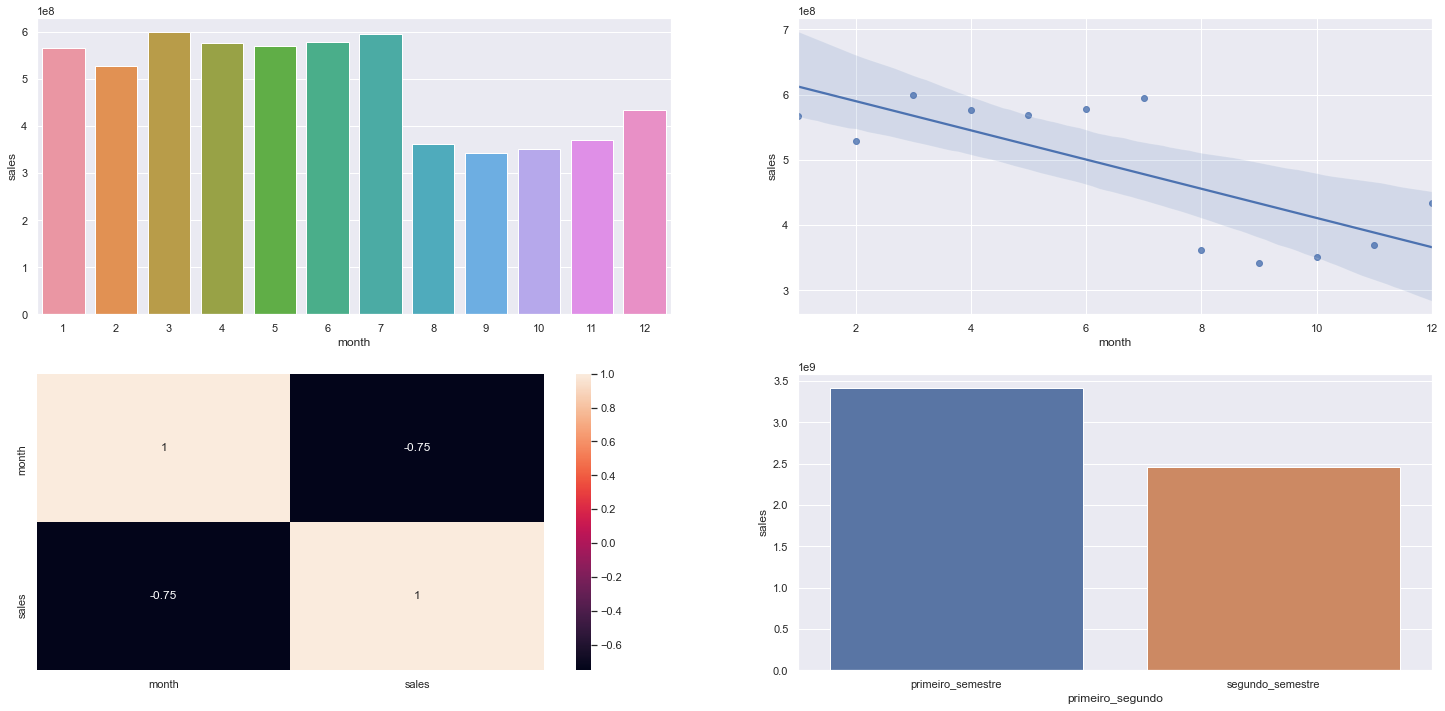

In [63]:
meses = df4[['month','sales']].groupby('month').sum().reset_index()


plt.subplot(2,2,1)
sns.barplot( x = 'month', y= 'sales', data =meses);

plt.subplot(2,2,2)
sns.regplot(x  = 'month', y = 'sales', data = meses);

plt.subplot(2,2,3)
sns.heatmap( meses.corr(method = 'pearson'), annot = True);

meses['primeiro_segundo'] = meses['month'].apply(lambda x: 'primeiro_semestre' if x < 7 else 'segundo_semestre')

plt.subplot(2,2,4)
meses = meses[['primeiro_segundo','sales']].groupby('primeiro_segundo').sum().reset_index()

sns.barplot(x = 'primeiro_segundo', y = 'sales', data = meses);


# H10 - Lojas deveriam vender menos aos finais de semana.

**Verdade:** As lojas vendem menos aos finais de semana

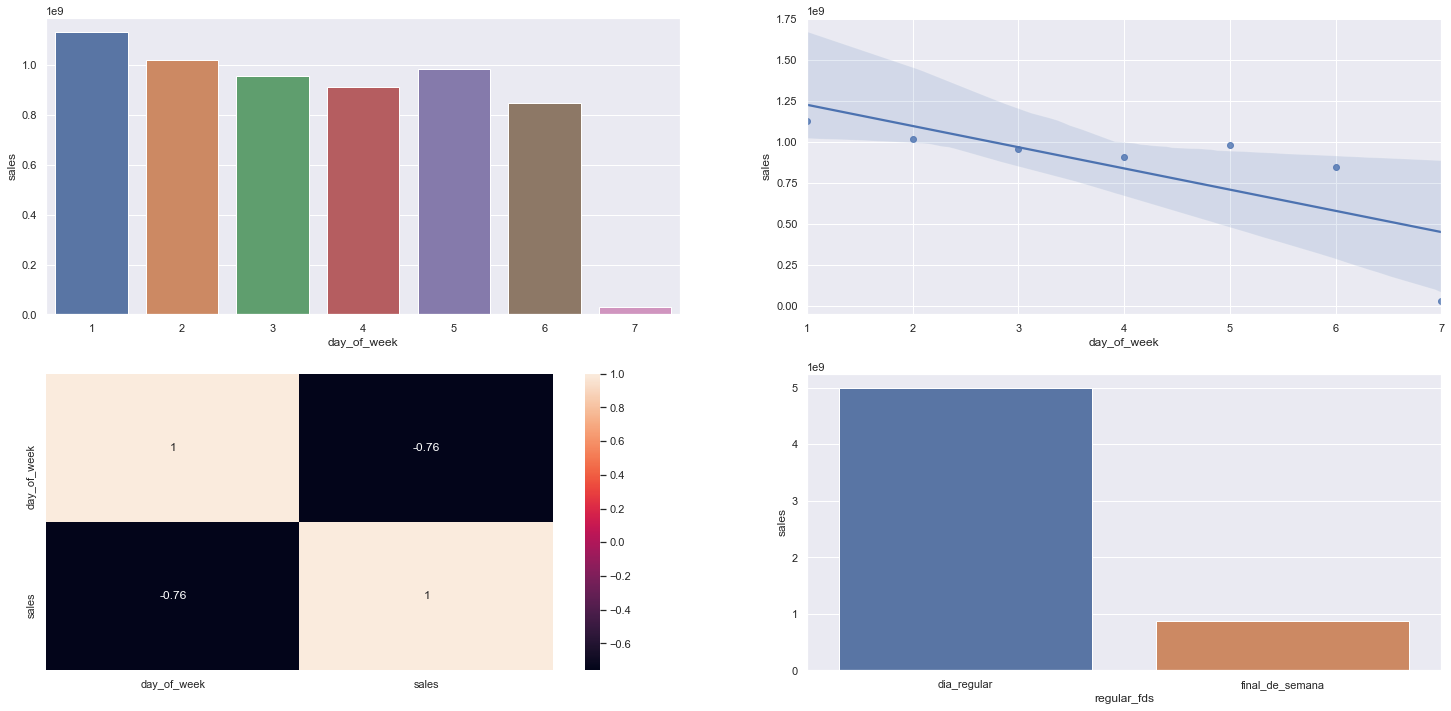

In [68]:
semana = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()


plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = semana);

plt.subplot(2,2,2)

sns.regplot(x = 'day_of_week',y= 'sales',data = semana);

plt.subplot(2,2,3)
sns.heatmap(semana.corr(method = 'pearson'), annot = True);

semana['regular_fds'] = semana['day_of_week'].apply(lambda x: 'final_de_semana' if x > 5 else 'dia_regular') 

plt.subplot(2,2,4)
semana = semana[['regular_fds','sales']].groupby('regular_fds').sum().reset_index()

sns.barplot(x = 'regular_fds', y = 'sales', data = semana);

# H10.  Lojas deveriam vender mais depois do dia 10 de cada mês.

***Falso:*** Depois do dia 10 de cada mÊs as lojas vendem menos.

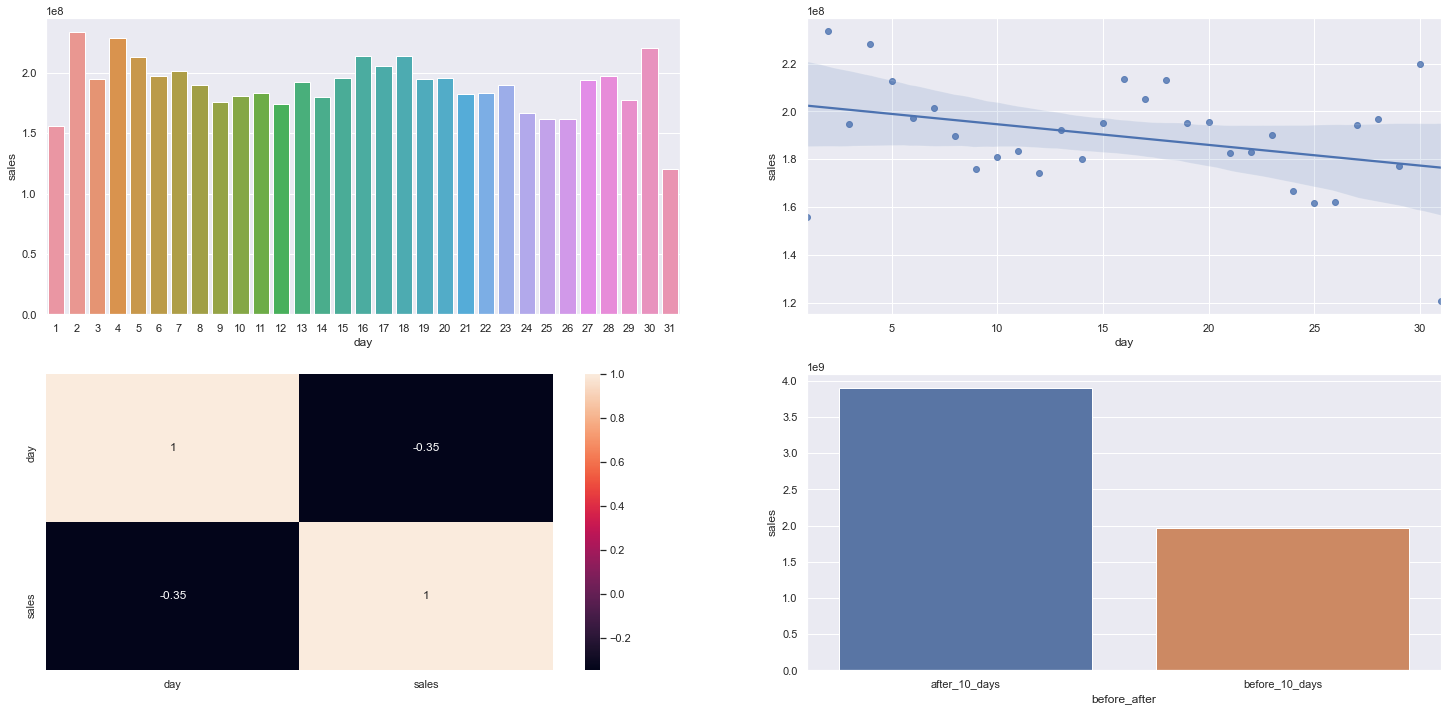

In [55]:
dias = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x ='day', y = 'sales', data = dias);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = dias);

plt.subplot(2,2,3)
sns.heatmap(dias.corr(method = 'pearson'), annot = True);

dias['before_after'] = dias['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
#linha do antes e depois do dia especifico(selecionar a coluna do especifica/ alicar função lambda x "variavel", se( If) for menor que dia 10, caso contrário
# será depois do dia 10

plt.subplot(2,2,4)
dias = dias[['before_after','sales']].groupby('before_after').sum().reset_index()

sns.barplot(x = 'before_after', y = 'sales', data = dias);

# H13. Lojas deveriam vender menos durante os feriados escolares

***Verdade:*** Lojas vendem menos nos feriados escolas, exceto nos feriados de julho e agosto.

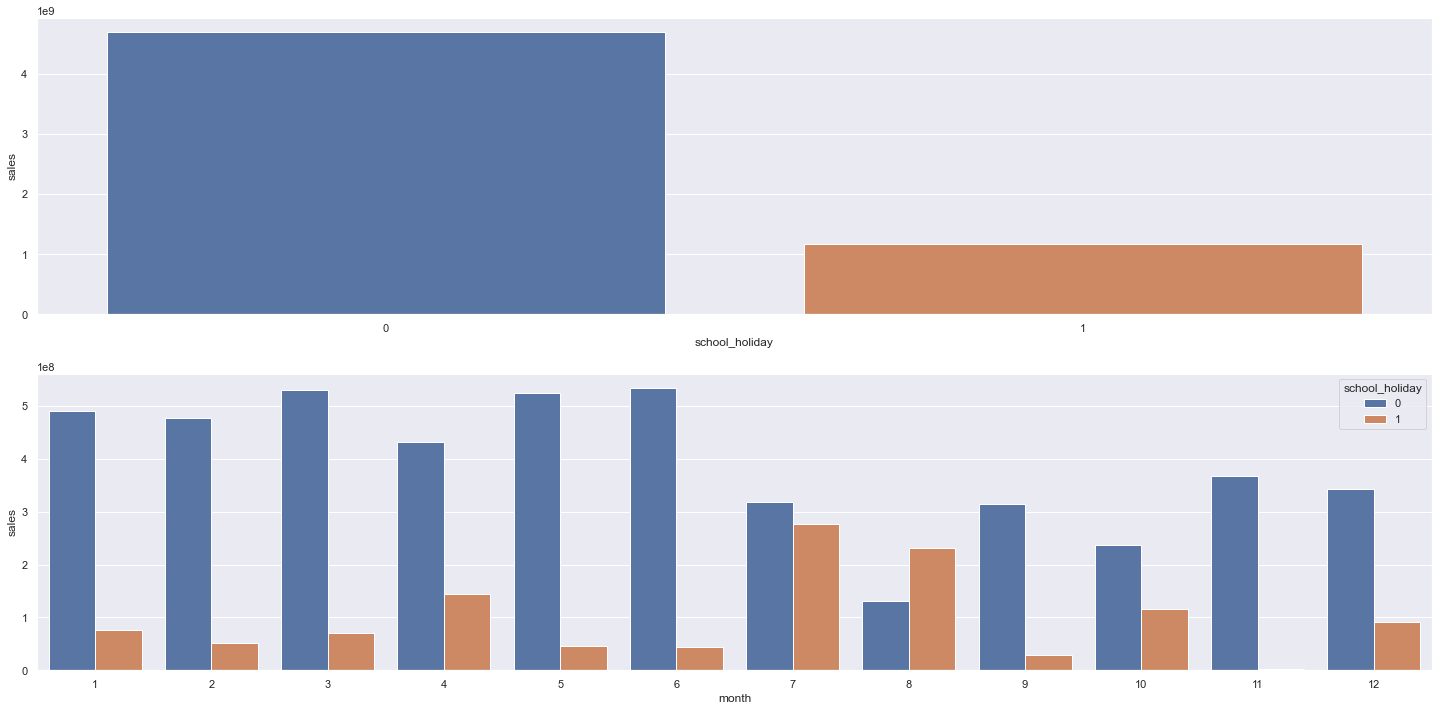

In [24]:
feriado_escolar = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y ='sales', data = feriado_escolar);

plt.subplot(2,1,2)
mes_escolar = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = mes_escolar);

# 4.2.1 Resumo das Hipotéses

In [25]:
# importar from tabulate import tabulate

In [24]:
tab = [['Hipoteses',' Conclusão','Relevância'], ['H1', 'Falsa', 'Baixa'],  ['H2', 'Falsa', 'Media'],  ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],]
    
print( tabulate( tab, headers='firstrow' ) )

## nesse passol faz importa a bibiloteca tabulate e cria um dicionário[] para transformar uma tabela! 

Hipoteses     Conclusão    Relevância
-----------  ------------  ------------
H1           Falsa         Baixa
H2           Falsa         Media
H3           Falsa         Media
H4           Falsa         Baixa
H5           -             -
H7           Falsa         Baixa
H8           Falsa         Media
H9           Falsa         Alta
H10          Falsa         Alta
H11          Verdadeira    Alta
H12          Verdadeira    Alta
H13          Verdadeira    Baixa


# 4.3 - Análise Multivariada

# 4.3.1  Numerical Attributes

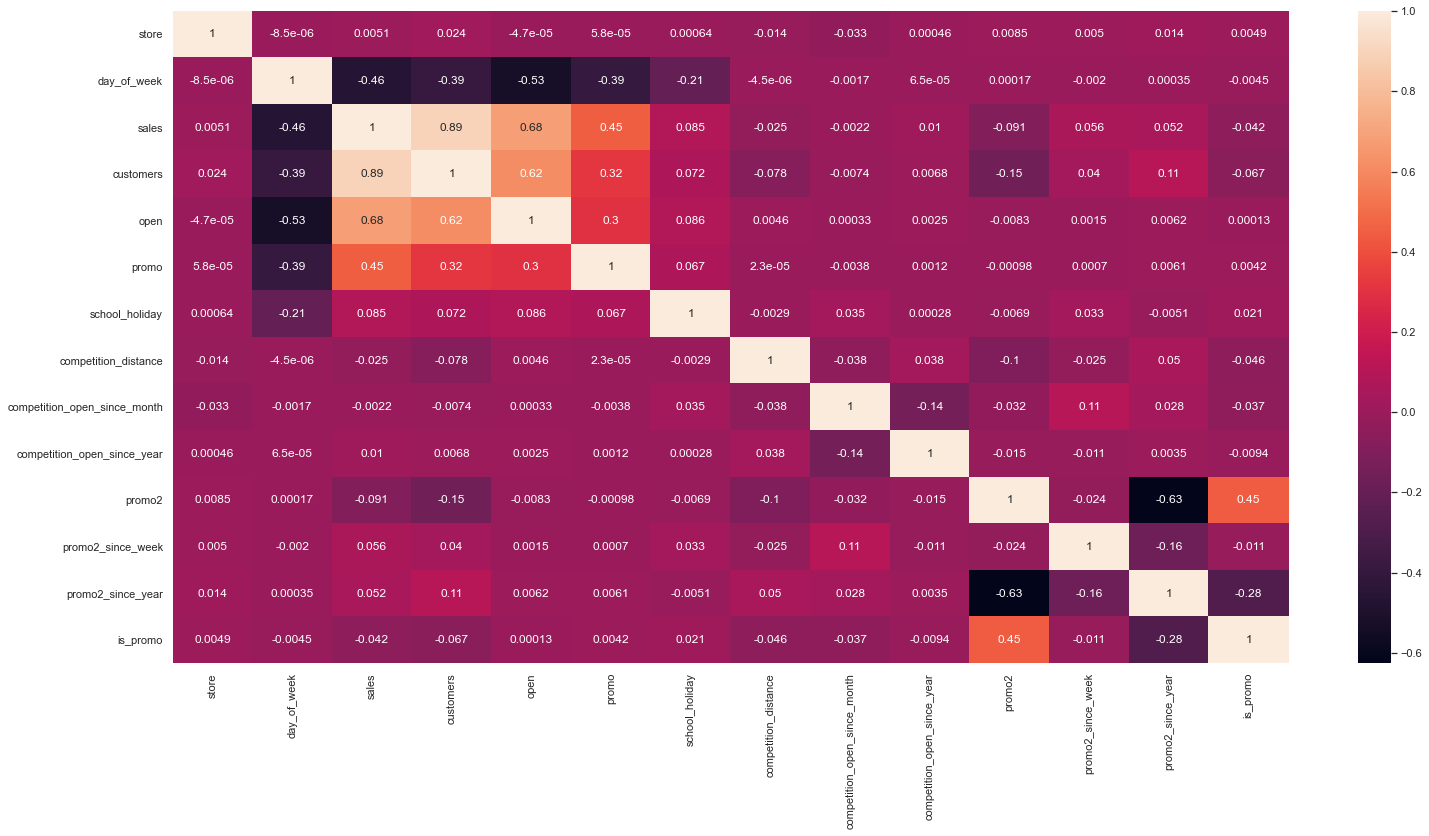

In [28]:
correlação = num_attributes.corr(method = 'pearson')
#método de pearson é um método para calcular 2 váriasvveis somente númericas (ou seja é impossível calcular por exemplo strings ou string(categorica) e uma númerica
# nesse método de pearson. - para isso será necessário calcular o métdo de Cream V)

sns.heatmap( correlação, annot = True);

# 4.3.1 - Categorical Attributes

In [34]:
categoricas = df4.select_dtypes( include= 'object')
#método select_dtypes tem como função selecionar algum tipo de coluna,no caso formatos em objetvos)

#Por que foram selecionadas colunas nesse estilo objeto nessa parte?

#resposta =  escolha desse tipo de colunas em formato de objetos(entende-se colunas categoricas) são o porque para aplicar o métdo Cream V.
# Pois através desse métdo Cream V que será possível fazer um calculo de correlação como o método de pearson. Como no exemlo abaixo
# é onde aparece somentes váriaveis strings (váriaveis categoricas). Resumindo tudo o que for letra/palavra será calculado por meio do Cream V.


In [35]:
categoricas.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [35]:
#https://minerandodados.com.br/dominando-o-pandas-datascience-dozero/#Crosstab (informação do método crosstab)

In [36]:
from scipy import stats as ss

#cm =pd.crosstab (categoricas['state_holiday'], categoricas['store_type']).values #(por ser uma matrix é necessário usar metodo ."values")

#nessa parte é feita uma cruzamento de das váriaveis categoricas. Ou seja, é montando um "tabuleiro" de correlações de objetos(strings). 

então é feito uma somátoria das linhas para saber quantos tipos tem daquela determina váriavel. Chamado de tabela de contigência ou matriz confusão.
 
na aula é chamado essa váriavel de "cm" (configuração da matriz) que é tabela feito com método crosstab. para ser usado no calculo V_cramer.


#matriz de confusão / tabela de contigência ( linha feita apenas para estudo)

#filtro para olhar como é "por dentro das linhas que aparece na tabela acima"

categoricas[(categoricas['store_type'] == 'a') & (categoricas['state_holiday'] == 'christmas')]


In [37]:
#nessa parte é aplicado a função de "V de cramer", para fazer a correlações das variaveis categoricas (strings)
# então deve-se aplicada cada função em cada váraivel para descobir sua correlação (lembrando que é sempre positiva, quanto mais perto do 1 mais relacionada)

categoricas_1 = cramer_v(categoricas['state_holiday'],categoricas['store_type'])
categoricas_2 = cramer_v(categoricas['state_holiday'],categoricas['assortment'])
categoricas_3 = cramer_v(categoricas['state_holiday'], categoricas['state_holiday'])

categoricas_4 = cramer_v(categoricas['store_type'],categoricas['state_holiday'])
categoricas_5 = cramer_v(categoricas['store_type'], categoricas['assortment'])
categoricas_6 = cramer_v(categoricas['store_type'], categoricas['store_type'])

categoricas_7 = cramer_v(categoricas['assortment'],categoricas['assortment'])
categoricas_8 = cramer_v(categoricas['assortment'],categoricas['store_type'])
categoricas_9 = cramer_v(categoricas['assortment'],categoricas['state_holiday'])



In [38]:
# nessa parte é feita um Data Frame das correlações feitas com a função de V_cramer. E depois é feito uma renomeção das colunas para 
# ficar mais a leitura da correlações (trocas os índices or nomes das váriaveis)

v_categoricas = pd.DataFrame ({'state_holiday': [categoricas_1,categoricas_2,categoricas_3],
                              'store_type': [categoricas_4,categoricas_5,categoricas_6],
                              'assorment': [categoricas_7,categoricas_8,categoricas_9]})

df_categoricas = v_categoricas.set_index(v_categoricas.columns)

In [39]:
df_categoricas.head()

,state_holiday,store_type,assorment
state_holiday,0.071065,0.071065,1.000001
store_type,0.067546,0.538457,0.538457
assorment,1.000002,1.000002,0.067546


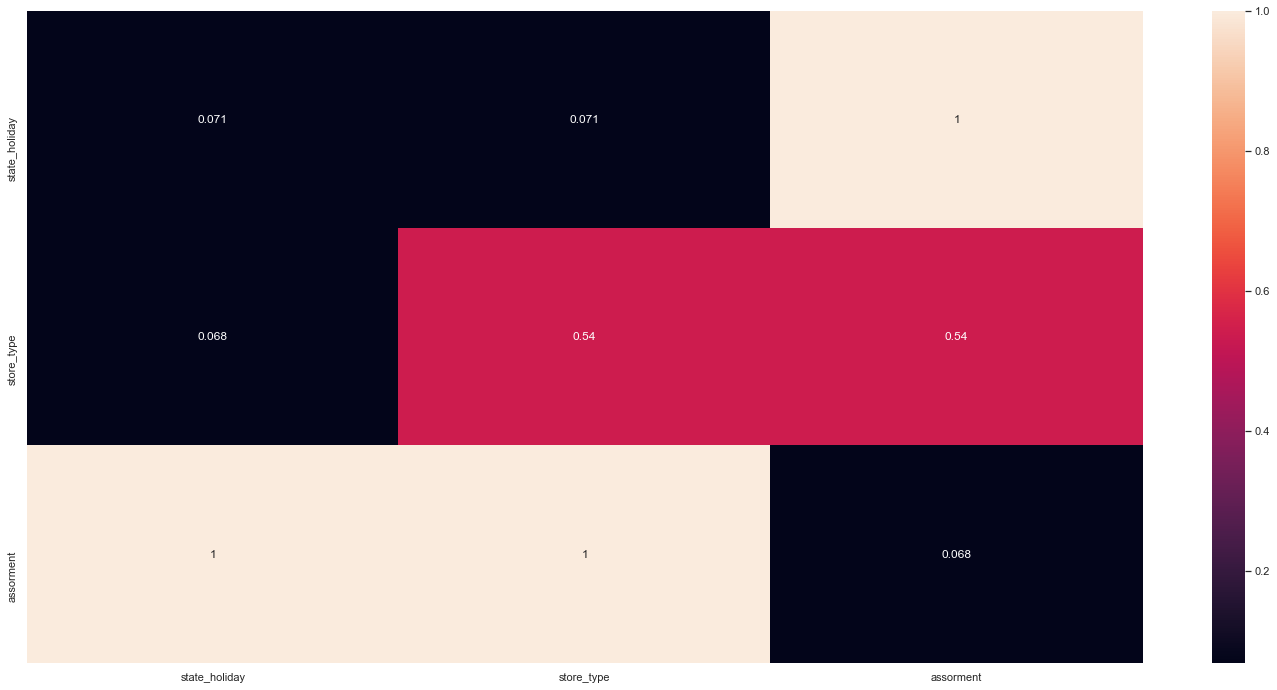

In [46]:
sns.heatmap(df_categoricas, annot = True);

# 5.0 - STEP DATA PREPARATION

In [40]:
df5 =df4.copy()

# 5.1 - NORMALIZAÇÃO

In [43]:
# https://www.aquare.la/a-distribuicao-normal-em-data-analytics/ (fonte - normalização)

# 5.2 - RESCALING 

***Rescaling é utilizado para váriaveis que não são normais. Ou seja, para váriavveis que apresentam valores(numéricos) muitos grandes e *** 
*** e com isso o modelo pode dá uma importância maior para esse números mais elevados. E com isso atrapalhar a acurancia dos testes ***

*** Então o rescaling tem como objtivo equalizar. Em outras palavras isso quer dizer que os valores que a coluna que eu escolher ***
*** serão alterados para uma nova escala numérica. Mas somente os valores dessas colunas. Para manter uma igualdade numérica. ***

In [41]:
a = df5.select_dtypes ( include = ['int','int64','float','float64'])
#primeira etapara fazer um min-max-scraling(rescarling) é selecionar todas as colunas c/ váraiaveis numéricas.

In [41]:
a.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
competition_distance,1270,570,14130,620,29910
competition_open_since_month,9,11,12,9,4
competition_open_since_year,2008,2007,2006,2009,2015
promo2,0,1,1,0,0
promo2_since_week,31,13,14,31,31


In [39]:
#selecionar as colunas numéricas que eu quero!

# day_of_week
# competition_distance
# month
# day
# competition_time_month
# promo_time_week
#year


C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


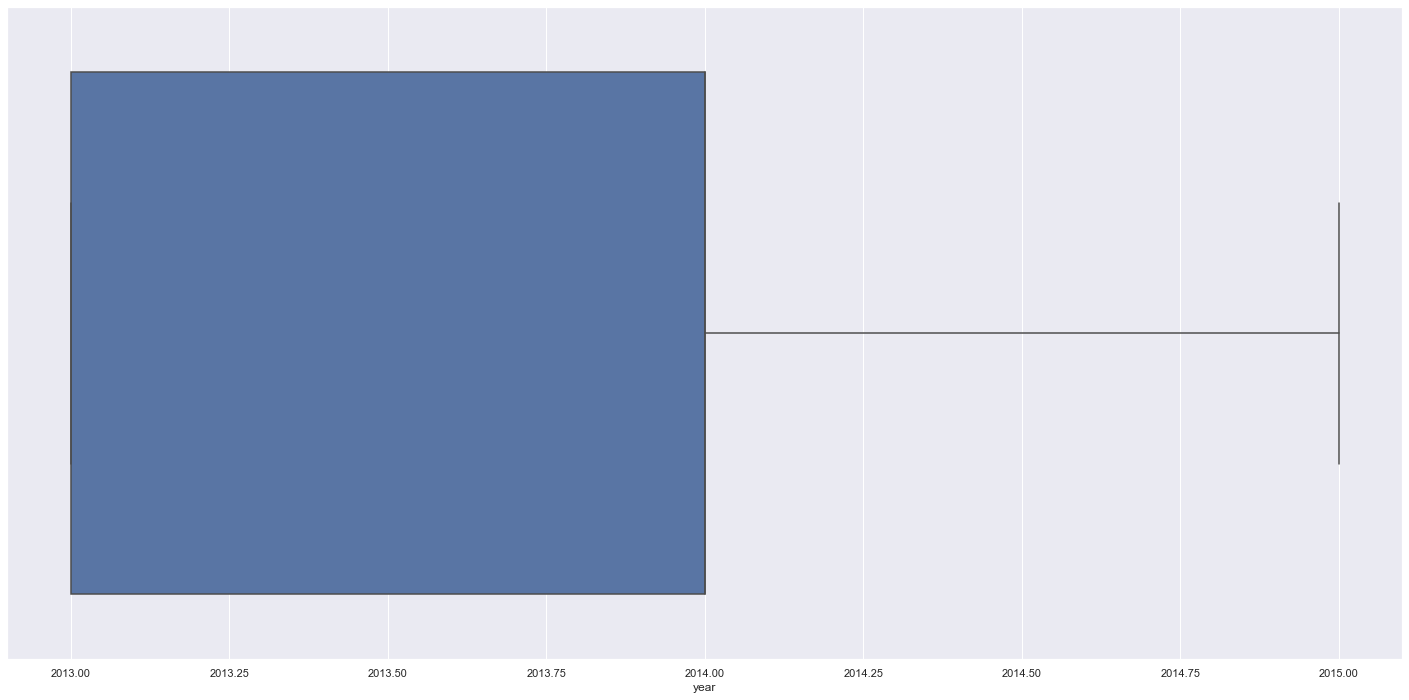

In [50]:
# https://www.aquare.la/o-que-sao-outliers-e-como-trata-los-em-uma-analise-de-dados/

#outliers podem ser definidos como algo que sai fora da normalidade/fora da curva. 


sns.boxplot(df5['year'] );

#nessa parte tem intuito de verificar o "antes da nova escola"

In [42]:
rs = RobustScaler()
mmr = MinMaxScaler()

## = RobusScaler é útil para váriaveis/colunas com valores com uma boa anormalidade (outlier)

## MinMaxSclaer tem como utilidade quando é o inverso do RobusScaler. Quando não tem outilier fora da curva. 

# e utilizando esses dois método, será possível configurar uma nova escola para o modelo de ML. E com isso evita falhas.  


In [43]:
#somente colunas que não repeten o ciclo. Que não volta ao seu ínicio. 

df5['competition_distance'] = rs.fit_transform(df5 [['competition_distance']].values)

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

df5['promo_time_week'] = mmr.fit_transform(df5[['promo_time_week']].values)

df5['year'] = mmr.fit_transform(df5[['year']].values)

#método fit_transfor serve para transformar a coluna que eu quero em uma nova escala. Junto c/ método RoburtScaler ou MinMaxScaler

C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


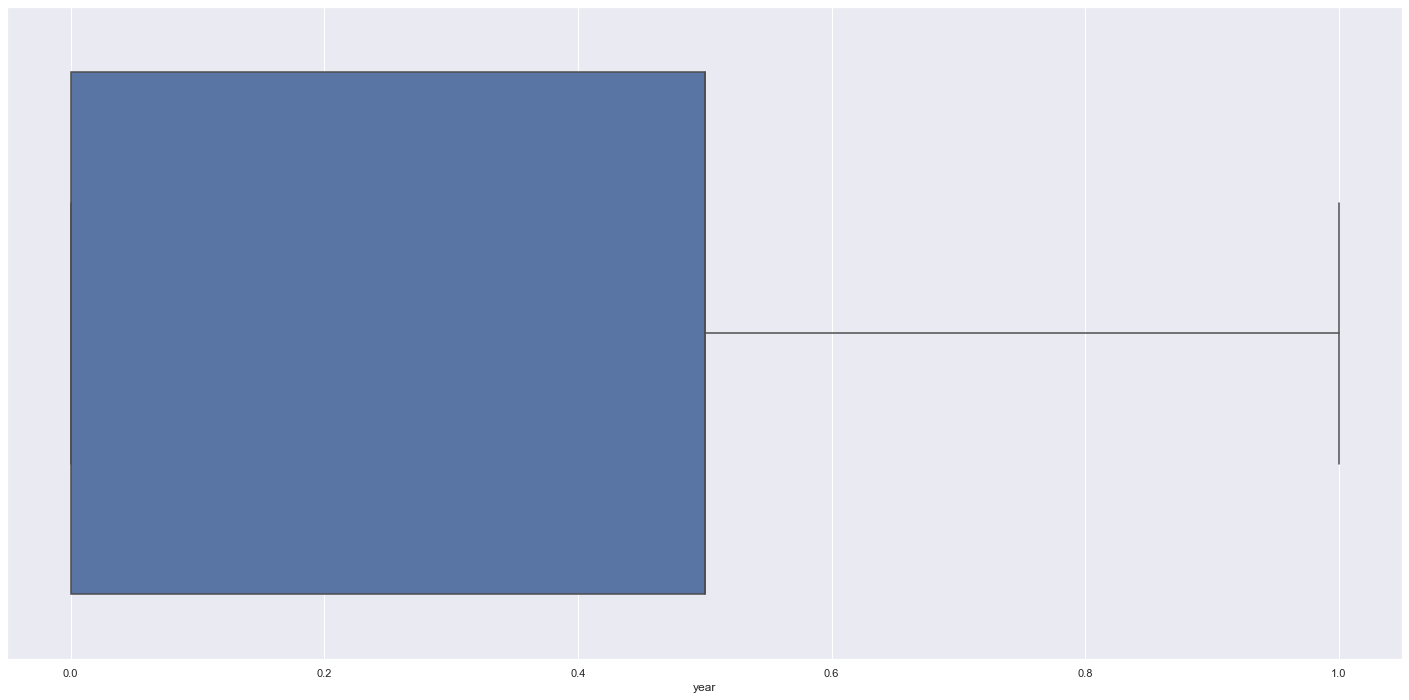

In [56]:
sns.boxplot(df5['year']);

C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


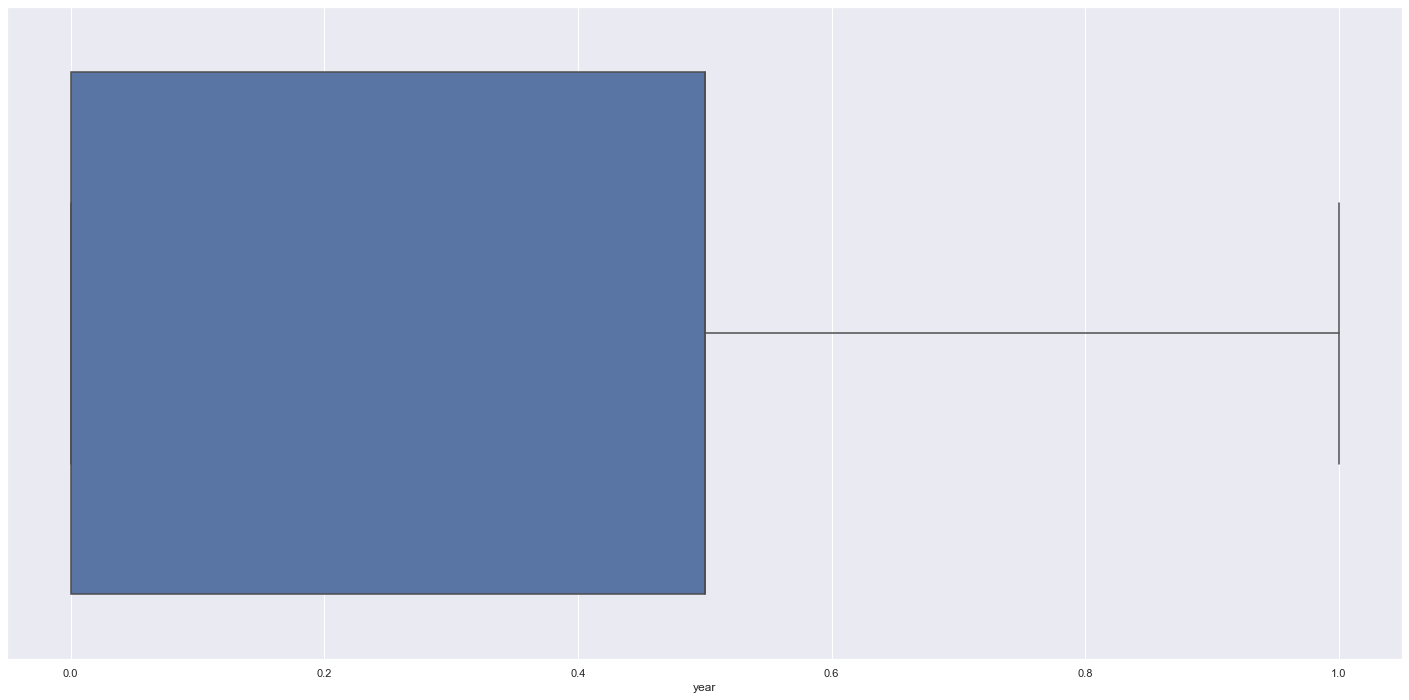

# 5.3 Transformação

##  5.3.1 Econding

***Encondig trata-se de transformar as váriaveis catégoricas em váriaveis númericas para usar no modelo de machine learning***

In [39]:
## váriaveis categoricas ## transformando categoricas em numéricas. 


#importar clase encoder

#store_type
#state_holiday
#assortment

In [44]:
# referência econding = http://contrib.scikit-learn.org/category_encoders/


# One hot = Pois os feriados são um estado (momento). Esse tipo de enconder é excelente para essa ocasião. 
df5 = pd.get_dummies( df5, prefix =['state_holiday'], columns =['state_holiday'])
 

# Target Encorder = usado em casos genéricos - ele  trocas as váriaveis categoricas (as letras) por numéros. 
le = LabelEncoder() 

df5['store_type'] = le.fit_transform(df5['store_type'])

#ordinal encoder = usado quando sabe-se que há uma hieraquia em váriaveis categoricas. Para isso é neessário fazer um dicionário e 
# depois mapear essa coluna. - Nesse caso é somente usando uma coluna. 

dict_assortment = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(dict_assortment)


In [45]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


# 5.3.2 - Response Variable Transformation

In [45]:
df5['sales'] = np.log1p(df5['sales'])

# 5.3.3 - Nature Transformation

***Nessa etapa é feita uma transformação nas econding (variaveis categoricas/string) que tem como caracteristia serem cicilicas, ou seja, voltam para o***
***estado inicial - no caso é muito comum em meses e dias***

In [42]:
# day
#month
# week of year
# day of week


In [46]:
# ***** aplicar função x: utilizado o método de sen ou cos e depois aplicar essa função x na muliplicar por 2 e dividir o circulo( pi) pelo tempo 
# desse cicio. No caso do dia é 30, meses é 12, dia da semana é 7, semanas do ano contém 52 semandas. Sempre ciclicas.

# cosseno multiplicado por 2x (pesquisa do Google)

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x *(2 * np.pi/30)))


#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12)))

# day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin (x * (2 * np.pi/7))) 
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos (x  * (2 * np.pi/7)))


#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos ( x * (2 * np.pi/52)))

# seno e cosseno são usados para medir  a distância. No caso a distância de tempo. Após a tranformação numérica. é uma espécie de mediana. 
# no caso calculano o seno é possível verificar que ele que todos os números daquele váraivel são modificados para um mesmo número. Ou seja a médiana
# geral de todos os itens no dataframe e é calculado o valor mais próximo daquela váriavel ciclica. 

In [48]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984


# 6 - Feature Selection 
***essa etapa é onde devemos selecionar as váriaveis que já foram transformadas em numéricas e que que tem mais relevancia para o modelo de ML.*** 

In [47]:
df6 = df5.copy()

In [48]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984


## 6.1 - Split dataframe into training and test dataset

In [48]:
# nessa etapa é onde eu retiro no DF as váriaveis originais e uso somente as váriaveis derivadas dessa original. Na etapa 3 foi feito a derivação.

cols_drop = ['competition_since','year','month','day','day_of_week','week_of_year','year_week','promo_since'] #váriaveis originais.Só fica derivadas

df6 = df6.drop(cols_drop, axis =1)

# 6.2 - Boruta as Feature Selection

In [49]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days= 7*6 )

# esse linha tem como função descobrir qual é a data máxima que os dados encontra-se. 

#leitura: seleciona a loja e a data,agrupa a loja por data, cria um novo índice, seleciona a data inicial e subtrair a data por alguns dias

#é necessário fazer isso para fazer a separação entre treino e teste. 
# A data abaixo vai ser o ponto de partido do treino. Dalí p/ frente é o teste
# dessa data p/ baixo é o treino do modelo.


Timestamp('2015-06-19 00:00:00')

In [50]:
#filtro para saber as datas. 

#treino do modelo (passado)
X_train = df6[df6['date'] < '2015-06-19']

y_train = X_train['sales']

# teste do modelo (futuro)

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

#esse treino e teste tem como função de separar o passado e o futuro.
#então devemos separar um trecho do período para supor que esse trecho é o futuro.
# e outro trecho do DF vai ser considerado o passado. 

print('Traning Min Date: {}'.format(X_train['date'].min( ) ) )
print('Traning Max Date: {}'.format(X_train['date'].max( ) ) )

print('\nTest Min Date: {}'.format(X_test['date'].min( ) ) )
print('Test Max Date: {}'.format(X_test['date'].max( ) ) ) 

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


# 6.2.1 - Boruta as Feature Selection

In [43]:


#x_train_n = x_train.drop(['date','sales'],axis =1).values
#excluindo a coluna de data (que não é numérica, até porque é original) e excluindo "sales" pois ele já está no eixo "y_train"

#y_train_n = y_train.values.ravel() #transforma em array(arranjo) ou seja um únco tipo


# método definido: RandomForestRegressor
# rf = RandomForestRegressor(n_jobs= -1) #método escolhido para boruta calcuar/transformar

#boruta = BorutaPy(rf,n_estimators = 'auto',verbose = 2, random_state =42 ).fit(x_train_n, y_train_n) (código original Boruta)

#boruta desrição do método
# 1º argumento é o método;
# 2º argumento = n_estimators = classificação(árvores)
#3] argumento verbose = descrição das etapas do Boruta
#4ª argumento random_state = ponto ínicial numérico da aleotoridade do treino e teste. 
# 5ª o método fit ( e tem que colocar vetores (conjunto de números), não pode ser Data Frame)
#obs: vetores https://mundoeducacao.uol.com.br/fisica/conceito-vetor.htm

#explicação que um array(arranjo): https://siteantigo.portaleducacao.com.br/conteudo/artigos/informatica/o-que-e-um-array/66596

#cols_select= boruta.support_tolist()
#esse método de suporte serve para fazer um ranking das colunas(váraiveis) mais importantes selecionado pelo Boruta

# x_train_nomes = x_train.drop(['date','sales'],axis =1) (código para incluir novamente e achar os índices)

#best feature boruta

#cols_select_nomes = x_train_nomes.iloc[:,cols_select].columns.tolist()

#colunas não selecionadas pelo Boruta:

#cols_not_select = list(np.setdiff1d(x_train_nomes.columns,cols_select_nomes))

In [51]:
cols_select_nomes = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# cols to add
feat_to_add =['date','sales']

cols_selected_boruta_full = cols_select_nomes.copy()

cols_selected_boruta_full.extend( feat_to_add )

In [42]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [ ]:
# modelo de Machine Learning Supervisionado. (Supervisão são quando eu coloco as entradas nos respectivos features) Ex.Coloco medidas de veículos

#Classificação = muito usado para classifcar (entende-se como associar) e dar a váraivel resposta como um único número/ Indentificar um carro, um ônibus
#ou no caso pass as entradas das doençs (no caso os sintomas são as entradas), de fraude (entradas são ações suspeitas)

# Modelo Regressão = semelhante a váraivel de classificação, porém a váriavel resposta é real. Usando quando as entradas da feature são calculadas
# para descobrir qual é a váriavel resposta. Exemplo preço estimado do carro aós passar as medidas deste veiculo. 

#(Série Temporiais) Predição = é usando como um modelo de previsão do futuro. Muito usando para prevêr vendas;quantidade de funcionarios que precisa, desgate do pneu.
# Aeérie temporais també conhecido como modelo regressão.

#mode não supervisionado = Quando não há ninguém informado quais features devo inclementar no modelo. Nesse caso eu faço uma cluaterização;
# clauterizaão pode ser entendido como separados das váriaveis (features) por grupos semelhantes de acordo com seus "formatos"(entradas).

# Método de ML por Reinforcement Learning = esse método é por meio de ação e recompensa. Ele trabalha por meio de exploração dos dados
# Por exemplo no catalogo de filmes na netflix ele sugere algumas capas de séries para as pessoas e as capas que tem mais clicks ele pontua como recompensa

In [52]:
def cross_validation( x_training, kfold, model_name, model, verbose= False ):  
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ): 
        if verbose:
            print('\nKFold Number: {}'.format( k ) )
            
        # start and end for validation of model's
        validation_start_date = x_training['date'].max() - timedelta( days= k*6*7)
        validation_end_date = x_training['date'].max() - timedelta ( days= (k-1)*6*7) 
    
        #filteringg the dataset
        training = x_training[x_training['date'] < validation_start_date ] 
        validation = x_training[( x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date)]
    
    
    
        # training and validation the datasets
        #traning
        xtraining = training.drop( ['date','sales'],axis=1 ) #nessa parte é retirado data e venda pois as datas não são contabilizadas e as vendas são eixo y                           
        ytraining = training['sales'] 
    
        #validation
        xvalidation = validation.drop(['date','sales'],axis =1)
        yvalidation = validation['sales']
    
        # model
        m = model.fit(xtraining,ytraining)
    
        #yhat
    
        yhat = model.predict(xvalidation)
    
        #performace
        ml_result =ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # store performace of each kfold interation
        mae_list.append( ml_result['Mae'] )
        mape_list.append( ml_result['Mape'] )
        rmse_list.append( ml_result['Rmse'] )
    
    return pd.DataFrame({'Model Name': model_name,
                          'MAPE CV':np.round(np.mean( mape_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'MAE CV': np.round(np.mean( mae_list ), 2).astype( str ) + '+/-' + np.round( np.std( mae_list ), 2 ).astype ( str ),
                          'RMSE CV': np.round(np.mean( rmse_list ), 2).astype( str ) + '+/-' + np.round( np.std (rmse_list), 2 ).astype( str ) } ,index=[0] ) 


# 7.0 Modelos de Machine Learning

In [53]:
# nesssa etapa é coletado os nomes selecionadas pelo boruta para fazer o processo de treino(passado) e o teste(futuro)
x_train = X_train[cols_select_nomes]
x_test = X_test[cols_select_nomes]

# Time series Data Preparation (Prediction )
x_training = X_train[cols_selected_boruta_full]

# 7.1 Average Model

In [54]:
aux1 = x_test.copy() #pegar os dados que foram separados no tópico anterior e será utilizado para fazer um test(prevêr o futuro)

aux1['sales'] = y_test.copy() #é add essa coluna "y_test" pois como feito anteriomente é derivada de um pedaço de um período das vendas(p/ estimar)

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns ={'sales' :'predictions'})
# linha de código usada para agrupar as lojas por média de vendas(sales) que será predictions no caso

aux1=pd.merge(aux1,aux2, how='left',on = 'store')
yhat_baseline = aux1['predictions']

#performace

baseline_resultado = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_resultado


,Model name,Mae,Mape,Rmse
0,Average Model,1354.800353,0.455051,1835.135542


#  7.2 Linear Regression Model


In [56]:
# importar from sklearn.linear_model import LinearRegression,Lasso

#https://medium.com/turing-talks/turing-talks-20-regress%C3%A3o-de-ridge-e-lasso-a0fc467b5629 conceito de Regressão Linear e Lasso.

In [47]:
lr = LinearRegression().fit( x_train, y_train)

#prediction

yhat_lr = lr.predict( x_test )

#perfomarce (resultado)

lr_result = ml_error ('Linear Regression', np.expm1( y_test), np.expm1( yhat_lr ))
lr_result

,Model name,Mae,Mape,Rmse
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Model - Cross Validation

In [63]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression-CV', lr, verbose= True)

lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAPE CV,MAE CV,RMSE CV
0,Linear Regression-CV,0.3+/-0.02,2081.73+/-295.63,2952.52+/-468.37


## 7.3 Linear Regression Model - Lasso


In [58]:
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction (previsão)

yhat_lasso = lrr.predict(x_test )

lr_lasso = ml_error ('Linear Regression Lasso', np.expm1( y_test), np.expm1( yhat_lasso))

lr_lasso

,Model name,Mae,Mape,Rmse
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


In [53]:
# https://didatica.tech/como-funciona-o-algoritmo-arvore-de-decisao/ (o que são árovres ciência de dados)

# https://levelup.gitconnected.com/random-forest-regression-209c0f354c84 ( oque é Ronom Forest Regression) - media de todas as árvores de predições

## 7.3.1 linear Regression Lasso - Cross Validation

In [64]:
lr_lasso_cv = cross_validation(x_training, 5 ,'Linear Regression Lasso Cross Validation',lrr,verbose=False)

lr_lasso_cv

,Model Name,MAPE CV,MAE CV,RMSE CV
0,Linear Regression Lasso Cross Validation,0.29+/-0.01,2116.38+/-341.5,3057.75+/-504.26


# 7.4 - Random Forest Regression Model

In [59]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train,y_train)

# n_estimators = quantidade de árovres de decisão  quantas serão construídas
# n_jobs = é a quantidade de árvores que serão construídas paralelamente (ou seja o mesmo tempo). Quanto menor número mais rápido vai executar. "-1" = 
# quantide de núcleo do computador. 


yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest Regression', np.expm1( y_test), np.expm1( yhat_rf))

rf_result

,Model name,Mae,Mape,Rmse
0,Random Forest Regression,679.598831,0.099913,1011.119437


## 7.4.1 Random Forest - Cross Validation

In [65]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAPE CV,MAE CV,RMSE CV
0,Random Forest Regressor,0.12+/-0.02,836.61+/-217.1,1254.3+/-316.17


# 7.5 - XGBoost Regressor Model

In [ ]:
#https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1 (método colsmple_tree)

In [60]:
xg_model = xgb.XGBRegressor ( objective = 'reg:squarederror',n_estimators =100, eta =0.01,max_depth=10,subsample=0.7,colsample_bytree=0.9).fit(x_train,y_train)
# n_estimators = são as quantidade de árvores
# eta = faz correções do algoristimo a cada boost
# subsample = é o paramêtro (em franção) que será usado para explocar as linha do banco de dados(dataset). Padrão é 1 que é = 100% das linhas
# colsample_bytree = quantidade de árvores que será coletados para amostra (semelhante a subsample, mas representa as colunas neste caso)
# math_depht = pode entender esse paramêtro como volta na árvore (tree) e retirar os galhas que não ajudam os nós das folhas. 

#"subsample" is the fraction of the training samples (randomly selected) that will be used to train each tree. 
#"colsample_by_tree" is the fraction of features (randomly selected) that will be used to train each tree.

yhat_xg = xg_model.predict(x_test)

xg_result= ml_error('XGBoost Regressor Model',np.expm1( y_test),np.expm1(yhat_xg))

xg_result

,Model name,Mae,Mape,Rmse
0,XGBoost Regressor Model,6683.423528,0.949439,7330.693347


## 7.5 -XGBoost - CROSS VALIDATION

In [66]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', xg_model, verbose=True )
xgb_result_cv

#https://medium.com/@keler.yohan/como-refinar-os-hiper-par%C3%A2metros-de-um-modelo-xgboost-em-python-a096f6ca8f14
# link sobre os parâmetros do xboost


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAPE CV,MAE CV,RMSE CV
0,XGBoost Regressor,0.95+/-0.0,7049.2+/-588.65,7715.2+/-689.51


# 7.6 Compare Model's Performance

## 7.6.1 Singles Performace

In [58]:
modelling_result = pd.concat( [baseline_resultado,xg_result,lr_result,lr_lasso,rf_result] )
modelling_result.sort_values('Rmse')

,Model name,Mae,Mape,Rmse
0,Random Forest Regression,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor Model,6683.423528,0.949439,7330.693347


## 7.6.2 Real Performace Cross Validation


In [68]:
modelo_validation_result = pd.concat([lr_result_cv,xgb_result_cv,rf_result_cv,lr_lasso_cv])
modelo_validation_result.sort_values('RMSE CV')

,Model Name,MAPE CV,MAE CV,RMSE CV
0,Random Forest Regressor,0.12+/-0.02,836.61+/-217.1,1254.3+/-316.17
0,Linear Regression-CV,0.3+/-0.02,2081.73+/-295.63,2952.52+/-468.37
0,Linear Regression Lasso Cross Validation,0.29+/-0.01,2116.38+/-341.5,3057.75+/-504.26
0,XGBoost Regressor,0.95+/-0.0,7049.2+/-588.65,7715.2+/-689.51


# STEP 8.0 -  HYPERPARAMETER FINE TUNING

In [54]:
import random 

In [49]:
param = {
         'n_estimators' :[15, 17, 25, 30, 35],
         'eta':[0.01, 0.03],
         'max_depth':[3,5,9],
         'subsample':[0.1,0.3,0.7],
         'colsample_bytree':[0.3,0.5,0.9],
         'min_child_weight': [3,8,15] }


MAX_EVAL = 5


In [59]:
#https://www.ti-enxame.com/pt/python/o-que-o-metodo-random.sample-em-python-faz/1046397287/ - método random.sample
#https://medium.com/siac/conhecendo-as-bibliotecas-padr%C3%A3o-random-parte-2-df522ec2db7 - métodos do random.sample e entre outros
#https://www.pythonprogressivo.net/2018/04/Funcao-range-O-que-e-Para-que-serve-Como-Usar.html - conceito do range

# nessa parte é feito inicialmente  apenas um teste de performace com intuito de descobri quais são os melhores paramêtros para usar no modelo final
# ou seja é feito apenas com poucas árvores de decisões (n_tree) para ser mais rápido

resultado_final =pd.DataFrame ()

#método de repetição
for i in range(MAX_EVAL ):
    #choose values randomly 
    hp = { k :random.sample (v,1)[0] for k, v in param.items() }
    print( hp )
    

  

    xg_model_hp = xgb.XGBRegressor ( objective ='reg:squarederror',
                                     n_estimators=hp['n_estimators'], 
                                     eta =hp['eta'],
                                     max_depth=hp['max_depth'],
                                     subsample=hp['subsample'],
                                     colsample_bytree=hp['colsample_bytree'],
                                     min_child_weight=hp['min_child_weight'] )
  

    resultado= cross_validation( x_training, 2, 'XGBoost  Regressor', xg_model_hp, verbose= False )

    resultado_final = pd.concat( [resultado_final,resultado] )

    
resultado_final


{'n_estimators': 25, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 3}
{'n_estimators': 15, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 3}


,Model Name,MAPE CV,MAE CV,RMSE CV
0,XGBoost Regressor,1.0+/-0.0,7416.22+/-128.29,8070.66+/-175.39
0,XGBoost Regressor,0.99+/-0.0,7392.5+/-128.18,8048.56+/-175.35


In [72]:
# conceito de RMSE : https://pt.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende

# 8.2 Final Model

In [59]:
param_tune = {
         'n_estimators' :3000,
         'eta':0.03,
         'max_depth':5,
         'subsample':0.7,
         'colsample_bytree':0.7,
         'min_child_weight': 3  }


In [60]:

 xg_model_tuned = xgb.XGBRegressor( objective= 'reg:squarederror',
                                    n_estimators =param_tune['n_estimators'],
                                    eta = param_tune['eta'],
                                    max_depth= param_tune['max_depth'],
                                    subsample=param_tune['subsample'],
                                    colsample_bytree = param_tune['colsample_bytree'],
                                    min_child_weight= param_tune['min_child_weight'] ).fit(x_train, y_train)

yhat_xg_tuned = xg_model_tuned.predict( x_test)
                           

xg_result_tuned = ml_error ('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xg_tuned) )

xg_result_tuned

,Model name,Mae,Mape,Rmse
0,XGBoost Regressor,767.867031,0.115342,1104.999627


In [98]:
# salvando o yhat no pickle
yhat_turnado = open('yhat_final','wb')

pickle.dump(yhat_xg_tuned,yhat_turnado)


In [101]:
yhat_turnado = open('yhat_final','rb')

pickle.load(yhat_turnado)

array([ 8.654972 ,  8.700775 ,  9.184986 , ...,  8.918571 , 10.0188875,
        9.054231 ], dtype=float32)

In [ ]:
# erro MAE :(média absoluta de erro )  ele soma todos os pontos dos erros(os negativos viram positvos) e dividi por pelo números de predições/valor real
# fácil de explicar para o time de négocio, pois ele é uma média geral. " A formula do erro seria Y (sales) - yhat" ou seja são os RANGE. 
# Coloca peso igual para todos os erros. ou seja, pode supor que ele coloca peso 1 nos pontos. Mesmo esse erro tendo erro 1,25, 1,5 ou 0,85.. 

# ERRO MAPE: (MÉDIA PORCENTAGEM DE ERRO): é um complemento de MAE.Ele representa o erro MAE em porcentagem. Bom uso para o cliente entender a diferença
# do erro. " Fórmua : Y - Yhat/  -Y". ( nesse caso é as Y (vendas) - yhat (estimativa) divido pelavs vendas"

# ERRO RMSE: (Erro elevado o quadrado do modelo): Ele eleva o qudrado os erros (outliers) ao quadrado. Ou seja, ao contrátio do MAE que coloca  pesos 
# iguais em todos os pontos de regressão, ele considera o valor real de todos os pontos. 
# é transformado em razi quadrada para ter real noção do erro dos Outliers. um exemplo seria o telhado de uma casa
# uma laje de 5x10 não é maior que uma laje 1x100, mesmo ela sendo mais extreitta. Transformado todos na mesma medida temos a real noção do erro
# É interessante olhar para sabemos qual é o menor erro do machine leaarn. Ou seja, existe pontos c/ erros de 1,25, 1,50, 0.85 e com isso ele tira
# a média exata de todos os erros.

In [99]:
# mpe = significa a media percentual de erros - isso que dizer que essa métrica utiliza a porcentagem da diferença dos erros:
# conceito : é pego o valor da predição subtraído pelo valor real. Com isso é divido pelo valor real do modelo * 100. . Soma todas as porcentagem e 
# é divido por todos os elementoss (pontos) que no caso é o "n ".

#https://imasters.com.br/data/metricas-para-algoritimos-de-regressao - coceito de métrica MPE
mpe = mean_percentage_error( np.expm1(y_test), np.expm1( yhat_xg_tuned) )
mpe

-0.01674668729407388

In [100]:
np.expm1(y_test).min( ) #valor mínimo da venda das últimas 6 semanas


569.0000000000002

In [101]:
np.expm1(y_test).max( ) # valor máximo da venda das últimas 6 semanas 

41550.99999999998

In [102]:
#range (diferença em reais) do valor da vendas das últimas 6 semanas (predição)
diferenca = np.expm1(y_test).max( ) - np.expm1(y_test).min( )
diferenca

40981.99999999998

In [103]:
#média de vendas em reais
np.expm1(y_test).mean( )

6995.162576094309

In [104]:
#média de erros do modelo
# média de vendas / pelo MAE 

767/6995 *100

10.964974982130094

# 9.0 - PASSO 09 - TRADUÇÃO E INTEPRETAÇÃO DOS ERROS

In [55]:
import pickle

In [58]:
#pickle.dump(diferenca,open)

In [102]:
df9= X_test[cols_selected_boruta_full]

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xg_tuned)

<ipython-input-102-440b070bad92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-102-440b070bad92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xg_tuned)


# 9.1 Bussines Performance

In [112]:
# soma das predições

df9_1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

#MAE ( erro norminal em reais)
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns ={0: 'Mae'} )

#MAPE (erro percentual em reais do MAE)
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions']) ).reset_index().rename(columns ={0: 'Mape'} )

# Merge (mesclar as colunas para montar um novo DF)
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how ='inner', on ='store') #aqui é para mesclar as colunas MAE e MAPE no novo DF
df9_2 = pd.merge( df9_1, df9_aux3, how ='inner', on = 'store') # qui é para mesclar o DF das soma das predições c/ as colunas de erros

# cenarios (acrecentando no Data Frame)
# wost scnearios

df9_2['worst_sceneario'] = df9_2['predictions'] - df9_2['Mae'] #dimunuindo a previsões das 6 semanas com a margem de erro

#best scnearios
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['Mae'] #somando as previsões das 6 semanas com a margem de erro

#ordem of columns

df9_2 = df9_2[['store','predictions','worst_sceneario','best_scenario','Mae','Mape']]



In [113]:
df9_2.sort_values('Mape',ascending = False).head()

,store,predictions,worst_sceneario,best_scenario,Mae,Mape
291,292,107615.710938,104215.942100,111015.479775,3399.768837,0.602434
908,909,218553.062500,210585.819187,226520.305813,7967.243313,0.520197
169,170,210332.781250,208754.922376,211910.640124,1577.858874,0.388893
901,902,202310.546875,200840.207863,203780.885887,1470.339012,0.366374
875,876,196113.046875,192048.999575,200177.094175,4064.047300,0.328779


<AxesSubplot:xlabel='store', ylabel='Mape'>

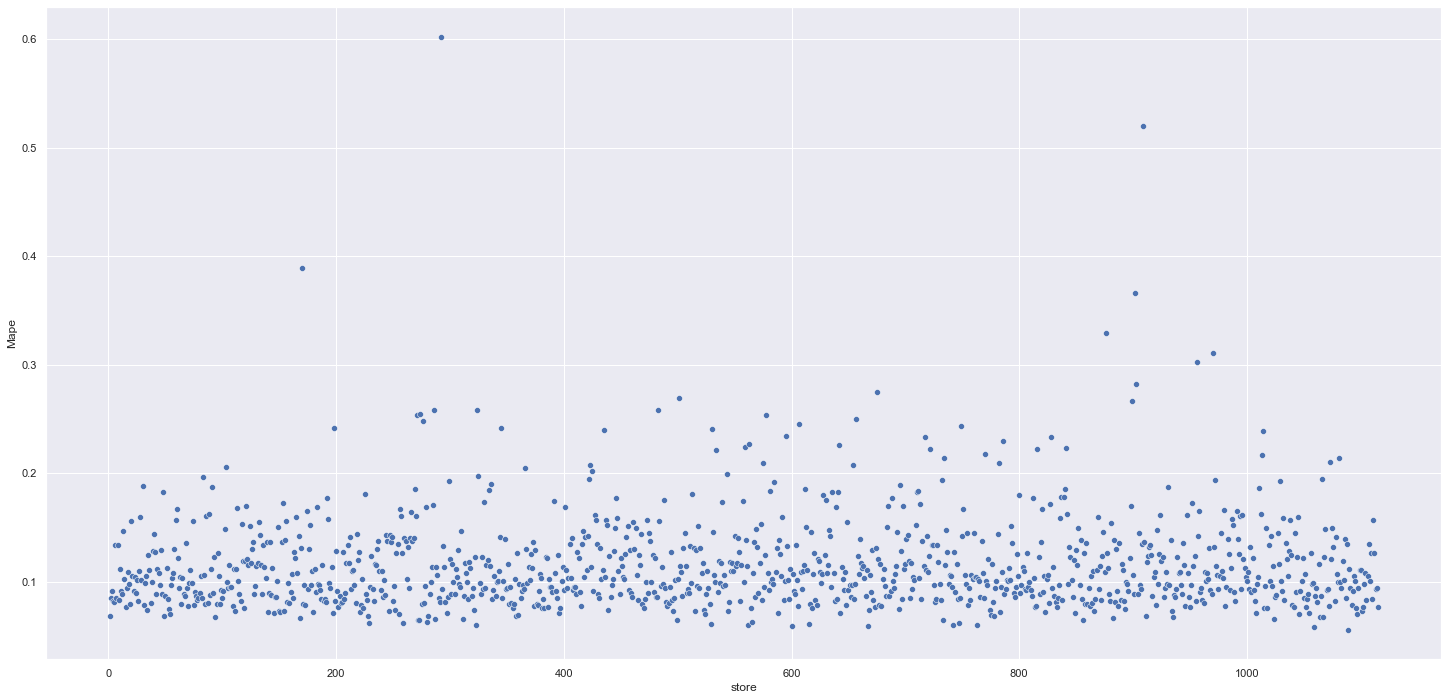

In [114]:
sns.scatterplot( x='store', y='Mape', data=df9_2 )

# 9.3 Total Performace

In [115]:
#soma de todas as lojas

df93 = df9_2[['predictions', 'worst_sceneario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93



,Scenario,Values
0,predictions,"R$285,982,336.00"
1,worst_sceneario,"R$285,122,909.38"
2,best_scenario,"R$286,841,799.87"


# 9.3 Machine Lean Performace

In [111]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-111-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-111-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrador.000\anaconda3\envs\DateScienteEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


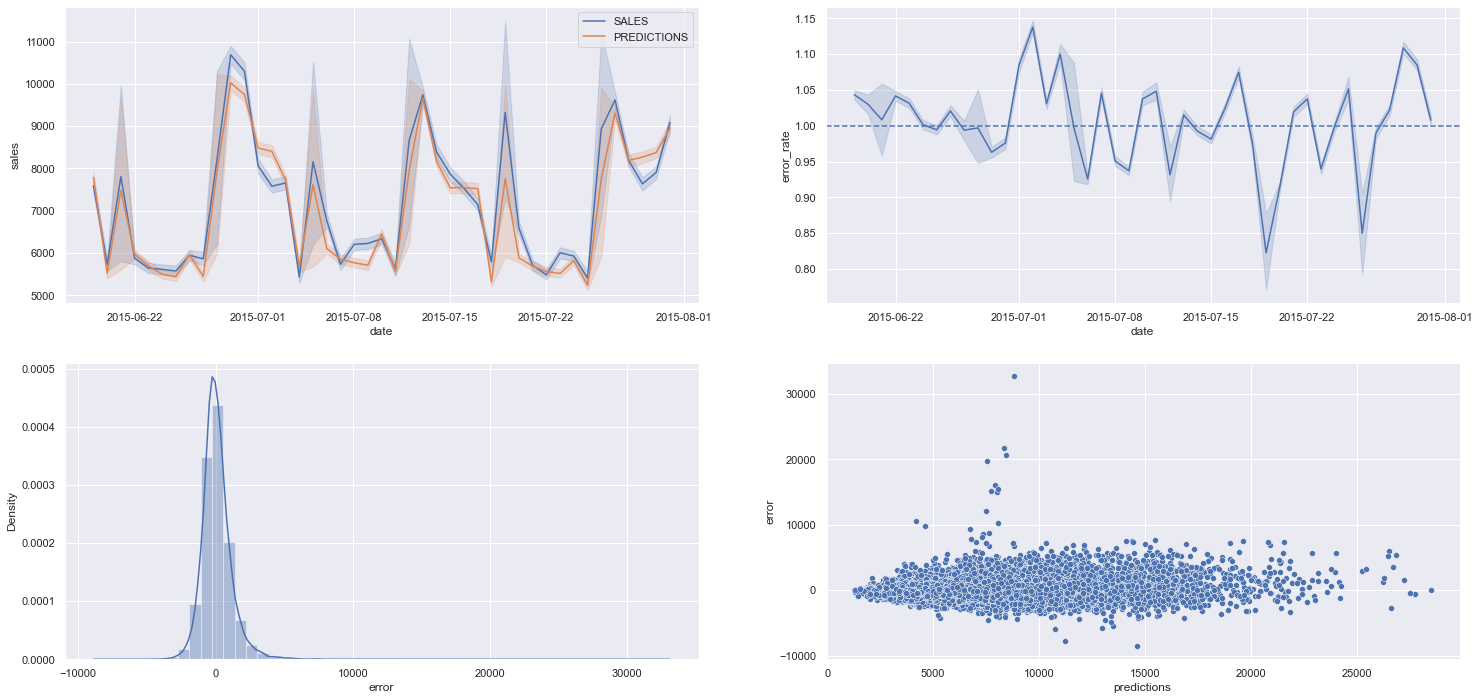

In [120]:
plt.subplot(2,2,1)
# gráfico criado para comparar todas as vendas de todas as lojas c/ as vendas das predições(previsões).
# se as previsões estão de acordo com as vendas de todas lojas ao longo do tempo
sns.lineplot(x = 'date', y ='sales', data = df9, label= 'SALES');
sns.lineplot(x ='date', y = 'predictions', data = df9, label = 'PREDICTIONS');

plt.subplot(2,2,2)
#gráfico criado para verficar a porcentagem de erros das vendas. o nº 1 representa a porcentagem perfeita sem erros
# a linha estando abaixo ou acima do número 1 quer dizer que o modelo está superestimado ou subestimação das vendas. 
sns.lineplot(x ='date',y= 'error_rate', data=df9);
plt.axhline(1, linestyle = '--');


plt.subplot(2,2,3)
# verificar se o modelo está dentro da normalidade de erro. 
sns.distplot( df9['error'] );

plt.subplot(2,2,4)
# verificar se as predições de todas as lojas não estão muito fora (tem que esta dentro de um tubo).
sns.scatterplot( df9['predictions'],df9['error'] );



In [125]:
#https://cursos.alura.com.br/forum/topico-erro-ao-salvar-um-modelo-de-rede-neural-ja-treinado-com-python-63809
# ensinando como salvar em pickle

# criando uma pasta para salvar o arquivo/objeto

arquivo_turnado = open('arquivo_turnado.pkl','wb') #wb signnifica write binary (escrito em binários)

# carregando o modelo dentro da pasta criada
pickle.dump(xg_model_tuned,arquivo_turnado)

#with open('model_rossmann.pkl', 'wb' ) as file: pickle.dumps(xg_model_tuned) 

In [126]:
# abrindo e lendo o modelo criado
arquivo_turnado = open('arquivo_turnado.pkl','rb')

#carregando o modelo salvo na pasta
modelo_carregado = pickle.load(arquivo_turnado)

In [127]:
modelo_carregado

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.03, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
import pickle

In [ ]:
with open('model_rossmann.pkl','rb') as model_rossmann: model_rossmann=pickle.load(model_rossmann)